# Regression

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
import time
from datetime import datetime
import os

In [7]:
df = pd.read_csv("../data/pub0225.csv")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Single unified results file
results_file = "reg_results.csv"

# Remove existing results file if it exists
if os.path.exists(results_file):
    os.remove(results_file)

def save_model_results(model_name, features, target, mae, mse, rmse, r2, mean_error_percent, 
                      train_time, method="Basic", parameters=None, cv_score=None):
    """
    Unified function to save all model results to a single CSV file.
    
    Parameters:
    - model_name: Name of the model (e.g., "DecisionTree", "RandomForest")
    - features: List of feature column names
    - target: Target column name
    - mae, mse, rmse, r2, mean_error_percent: Model performance metrics
    - train_time: Training time in seconds
    - method: Method used ("Basic", "Manual Tuning", "GridSearchCV")
    - parameters: String representation of parameters used (for tuning)
    - cv_score: Cross-validation score (for GridSearch)
    """
    features_str = ", ".join(features) if len(features) > 1 else features[0]
    
    # Create consistent result data structure with standardized column names
    result_data = {
        "Record Time": datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f"),
        "Train Time (s)": round(train_time, 3),
        "Method": method,
        "Model Name": model_name,
        "Feature Columns": features_str,
        "Target Column": "Wage (CAD/hour)",
        "Parameters": parameters if parameters else "",
        "CV Score (R²)": round(cv_score, 3) if cv_score else "",
        "R Square Score": round(r2, 3),  # Standardized column name
        "Mean Absolute Error (MAE)": round(mae, 3),
        "Mean Squared Error (MSE)": round(mse, 3),
        "Root Mean Squared Error (RMSE)": round(rmse, 3),
        "Mean Error Percentage (%)": round(mean_error_percent, 3),
    }
    
    # Append to CSV file
    result_df = pd.DataFrame([result_data])
    if os.path.exists(results_file):
        result_df.to_csv(results_file, mode="a", header=False, index=False)
    else:
        result_df.to_csv(results_file, mode="w", header=True, index=False)
    
    return result_data

Dataset shape: (113780, 60)
Columns: ['REC_NUM', 'SURVYEAR', 'SURVMNTH', 'LFSSTAT', 'PROV', 'CMA', 'AGE_12', 'AGE_6', 'GENDER', 'MARSTAT', 'EDUC', 'MJH', 'EVERWORK', 'FTPTLAST', 'COWMAIN', 'IMMIG', 'NAICS_21', 'NOC_10', 'NOC_43', 'YABSENT', 'WKSAWAY', 'PAYAWAY', 'UHRSMAIN', 'AHRSMAIN', 'FTPTMAIN', 'UTOTHRS', 'ATOTHRS', 'HRSAWAY', 'YAWAY', 'PAIDOT', 'UNPAIDOT', 'XTRAHRS', 'WHYPT', 'TENURE', 'PREVTEN', 'HRLYEARN', 'UNION', 'PERMTEMP', 'ESTSIZE', 'FIRMSIZE', 'DURUNEMP', 'FLOWUNEM', 'UNEMFTPT', 'WHYLEFTO', 'WHYLEFTN', 'DURJLESS', 'AVAILABL', 'LKPUBAG', 'LKEMPLOY', 'LKRELS', 'LKATADS', 'LKANSADS', 'LKOTHERN', 'PRIORACT', 'YNOLOOK', 'TLOLOOK', 'SCHOOLN', 'EFAMTYPE', 'AGYOWNK', 'FINALWT']


In [8]:
def train_and_evaluate_model(df, features, target, model, model_name, method="Basic", 
                            parameters=None, cv_score=None, show_plot=True):
    """
    Unified function to train and evaluate any regression model.
    
    Parameters:
    - df: DataFrame containing the data
    - features: List of feature column names
    - target: Target column name
    - model: Instantiated sklearn model
    - model_name: Name of the model for reporting
    - method: Method used ("Basic", "Manual Tuning", "GridSearchCV")
    - parameters: String representation of parameters (for tuning methods)
    - cv_score: Cross-validation score (for GridSearch)
    - show_plot: Whether to show visualization plots
    """
    start_time = time.time()
    
    # Preprocess data
    df_clean = df.copy()
    df_clean["HRLYEARN"] = df_clean["HRLYEARN"] / 100
    
    if "AGE_12" in features:
        df_clean["AGE_12"] = 10 + df_clean["AGE_12"] * 5
    
    # Select required columns and drop nulls
    df_model = df_clean[features + [target]].dropna()
    print(f"Data after preprocessing: {df_model.shape[0]} rows")
    
    if len(df_model) == 0:
        print("ERROR: No data remaining after preprocessing!")
        return None
    
    X, y = df_model[features], df_model[target]
    
    # Split and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Handle GridSearchCV differently
    if hasattr(model, 'fit'):
        if hasattr(model, 'best_estimator_'):  # Already fitted GridSearchCV
            fitted_model = model
            if cv_score is None:
                cv_score = model.best_score_
            if parameters is None:
                parameters = str(model.best_params_)
        else:
            fitted_model = model.fit(X_train, y_train)
            if hasattr(model, 'best_estimator_'):  # GridSearchCV
                if cv_score is None:
                    cv_score = model.best_score_
                if parameters is None:
                    parameters = str(model.best_params_)
    else:
        print("ERROR: Model does not have fit method!")
        return None
    
    train_time = time.time() - start_time
    
    # Evaluate
    if hasattr(fitted_model, 'predict'):
        y_pred = fitted_model.predict(X_test)
    elif hasattr(fitted_model, 'best_estimator_'):
        y_pred = fitted_model.best_estimator_.predict(X_test)
    else:
        print("ERROR: Cannot make predictions!")
        return None
        
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mean_error_percent = (rmse / np.mean(y_pred)) * 100
    
    # Print results
    features_str = ", ".join(features) if len(features) > 1 else features[0]
    print(f"\n{method} {model_name} with {features_str}:")
    if parameters:
        print(f"Parameters: {parameters}")
    if cv_score:
        print(f"CV R² Score: {cv_score:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): ${mae:.4f}")
    print(f"Mean Squared Error (MSE): ${mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.4f}")
    print(f"Mean Error Percentage: {mean_error_percent:.2f}%")
    
    # Visualization
    if show_plot:
        plt.figure(figsize=(12, 5))
        
        if len(features) == 1:
            # Single feature: scatter plot
            plt.subplot(1, 2, 1)
            plt.scatter(X_test[features[0]], y_test, alpha=0.6, label="Actual", s=30, color="black")
            plt.scatter(X_test[features[0]], y_pred, alpha=0.6, label="Predicted", s=30, color="red")
            plt.xlabel(features[0])
            plt.ylabel("Hourly Wage ($)")
            plt.title(f"{method} {model_name}: {features[0]} vs Wage")
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Predicted vs Actual
            plt.subplot(1, 2, 2)
            plt.scatter(y_test, y_pred, alpha=0.6, s=30, color="blue")
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=2)
            plt.xlabel("Actual Wage ($)")
            plt.ylabel("Predicted Wage ($)")
            plt.title("Predicted vs Actual")
            plt.grid(True, alpha=0.3)
        else:
            # Multi-feature: predicted vs actual
            plt.subplot(1, 1, 1)
            plt.scatter(y_test, y_pred, alpha=0.6, s=30, color="blue")
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=2)
            plt.xlabel("Actual Wage ($)")
            plt.ylabel("Predicted Wage ($)")
            plt.title(f"{method} {model_name}: Actual vs Predicted ({features_str})")
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Save results using unified function
    result_data = save_model_results(
        model_name=model_name,
        features=features,
        target=target,
        mae=mae,
        mse=mse,
        rmse=rmse,
        r2=r2,
        mean_error_percent=mean_error_percent,
        train_time=train_time,
        method=method,
        parameters=parameters,
        cv_score=cv_score
    )
    
    print(f"Results saved to {results_file}")
    
    # Feature importance for multi-feature models
    actual_model = fitted_model.best_estimator_ if hasattr(fitted_model, 'best_estimator_') else fitted_model
    if len(features) > 1 and hasattr(actual_model, 'feature_importances_'):
        print("\nFeature Importance:")
        for feature, importance in zip(features, actual_model.feature_importances_):
            print(f"  {feature}: {importance:.3f}")
    
    # Model-specific information
    if hasattr(actual_model, 'get_depth'):  # Decision Tree
        print(f"Tree depth: {actual_model.get_depth()}, Leaves: {actual_model.get_n_leaves()}")
    elif hasattr(actual_model, 'n_estimators'):  # Ensemble methods
        print(f"Number of estimators: {actual_model.n_estimators}")
        if hasattr(actual_model, 'max_depth'):
            print(f"Max depth: {actual_model.max_depth}")
    
    return {
        "model": fitted_model,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "metrics": result_data,
    }

## Decision Tree

In [9]:
def decision_tree(df, features, target, max_depth=10, model_name="DecisionTree"):
    """
    Train and evaluate a Decision Tree regression model.
    """
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    return train_and_evaluate_model(
        df=df, 
        features=features, 
        target=target, 
        model=model, 
        model_name=model_name,
        method="Basic"
    )

Data after preprocessing: 57015 rows

Basic DecisionTree with AGE_12:
R² Score: 0.1083
Mean Absolute Error (MAE): $12.7885
Mean Squared Error (MSE): $325.4362
Root Mean Squared Error (RMSE): $18.0398
Mean Error Percentage: 50.82%


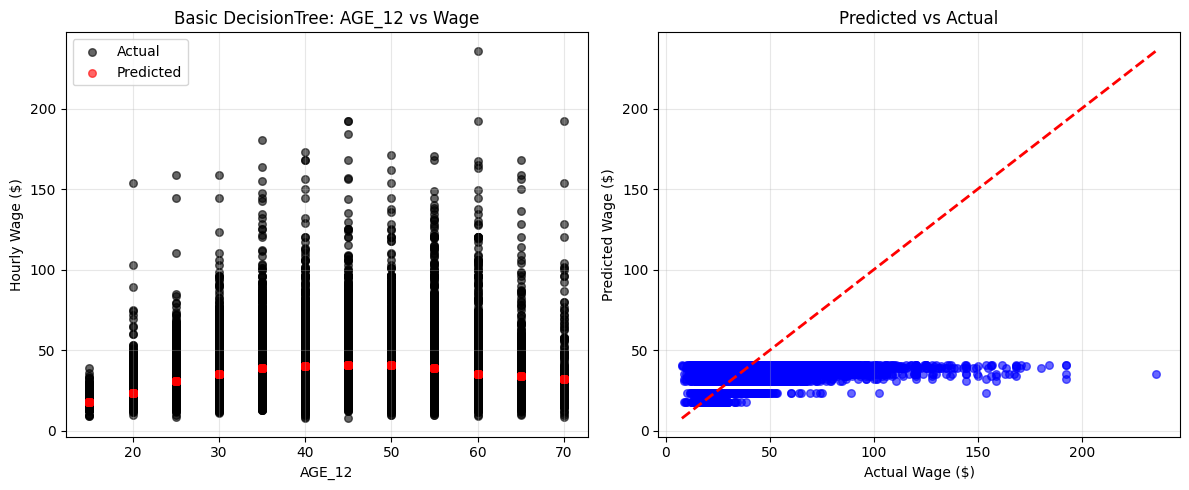

Results saved to reg_results.csv
Tree depth: 7, Leaves: 12


In [10]:
# Single feature test
result1 = decision_tree(df, ["AGE_12"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic DecisionTree with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7859
Mean Squared Error (MSE): $325.3944
Root Mean Squared Error (RMSE): $18.0387
Mean Error Percentage: 50.83%


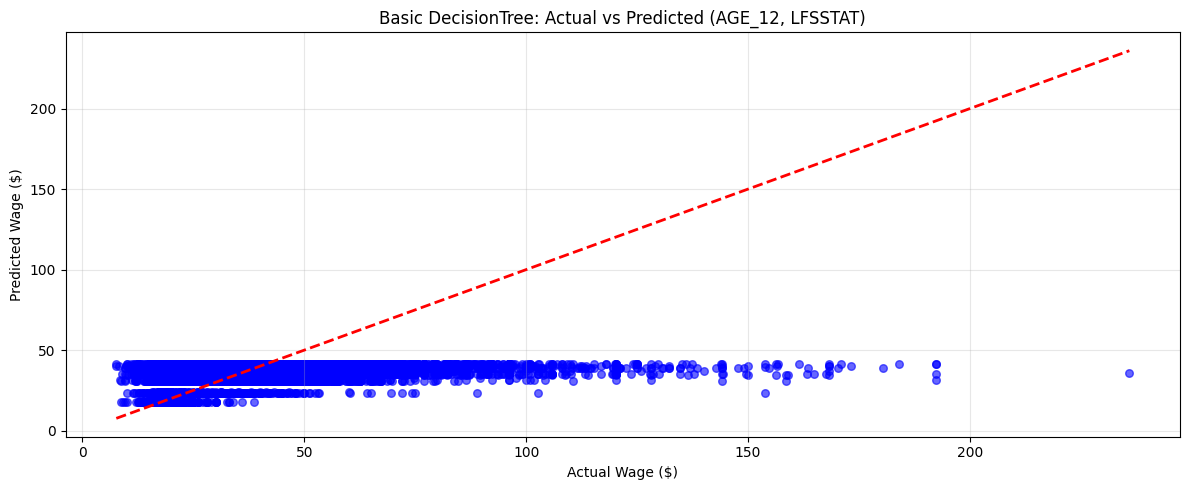

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.993
  LFSSTAT: 0.007
Tree depth: 8, Leaves: 24


In [11]:
# Multiple features test
result2 = decision_tree(df, ["AGE_12", "LFSSTAT"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic DecisionTree with AGE_12, LFSSTAT:
R² Score: 0.1088
Mean Absolute Error (MAE): $12.7839
Mean Squared Error (MSE): $325.2613
Root Mean Squared Error (RMSE): $18.0350
Mean Error Percentage: 50.82%


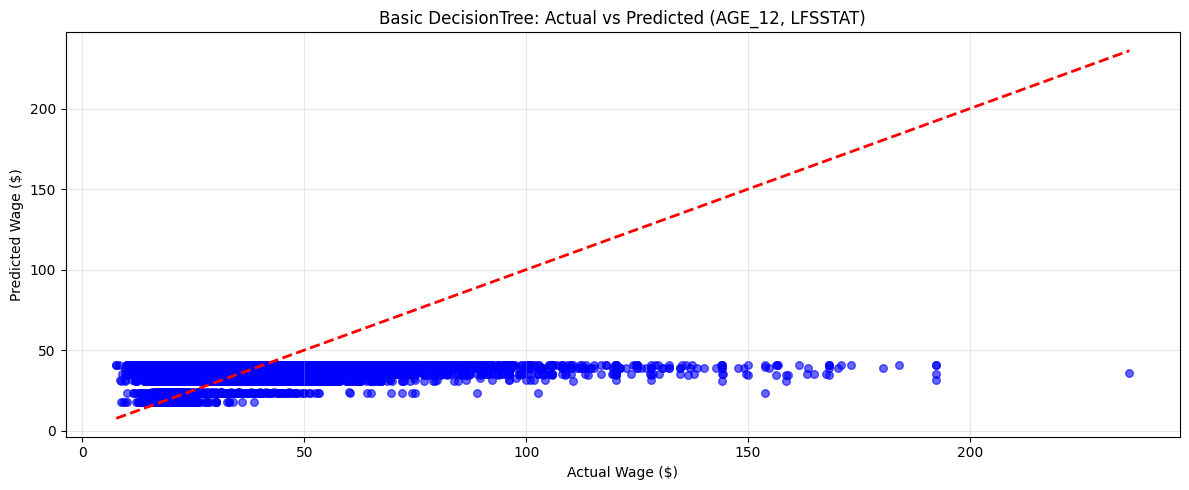

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.997
  LFSSTAT: 0.003
Tree depth: 5, Leaves: 18


In [12]:
# Test with different depth
result3 = decision_tree(df, ["AGE_12", "LFSSTAT"], "HRLYEARN", 
                        max_depth=5)

Data after preprocessing: 57015 rows

Basic DecisionTree with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2321
Mean Absolute Error (MAE): $11.4557
Mean Squared Error (MSE): $280.2492
Root Mean Squared Error (RMSE): $16.7406
Mean Error Percentage: 47.13%


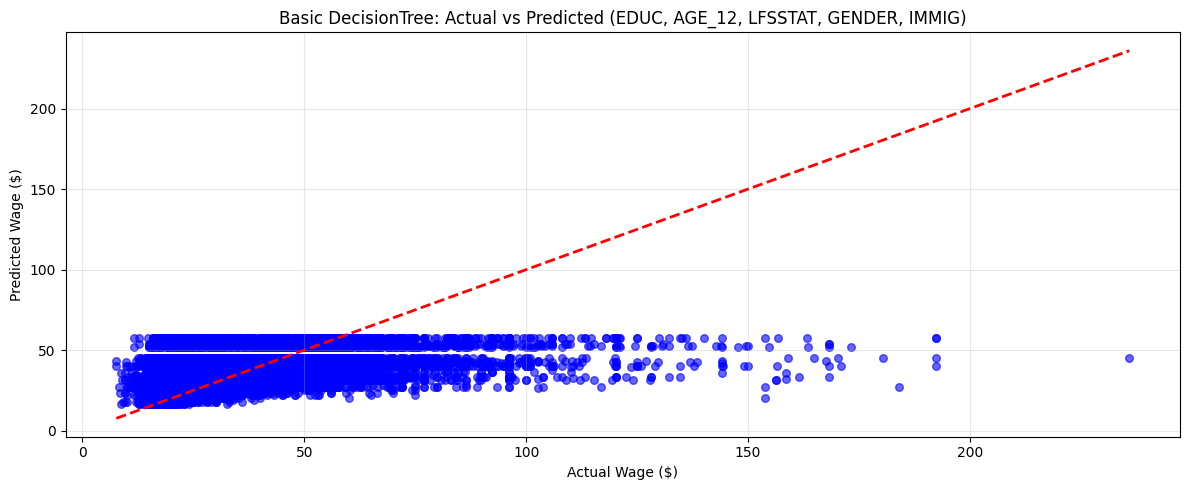

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.516
  AGE_12: 0.338
  LFSSTAT: 0.000
  GENDER: 0.101
  IMMIG: 0.045
Tree depth: 5, Leaves: 32
Data after preprocessing: 57015 rows

Basic DecisionTree with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2390
Mean Absolute Error (MAE): $11.3111
Mean Squared Error (MSE): $277.7268
Root Mean Squared Error (RMSE): $16.6651
Mean Error Percentage: 46.92%


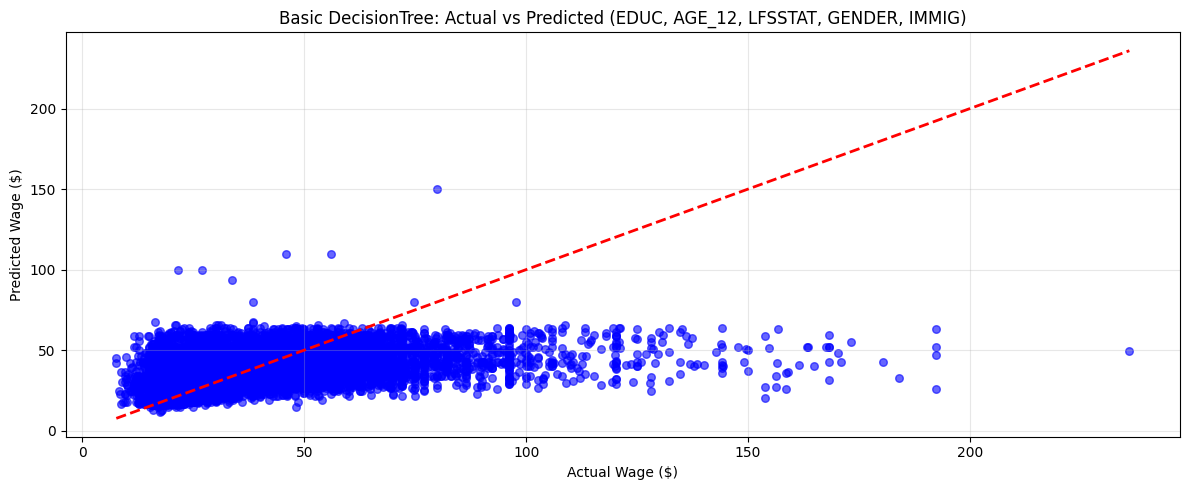

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.476
  AGE_12: 0.354
  LFSSTAT: 0.010
  GENDER: 0.092
  IMMIG: 0.067
Tree depth: 10, Leaves: 485
Data after preprocessing: 57015 rows

Basic DecisionTree with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2337
Mean Absolute Error (MAE): $11.3500
Mean Squared Error (MSE): $279.6839
Root Mean Squared Error (RMSE): $16.7238
Mean Error Percentage: 47.10%


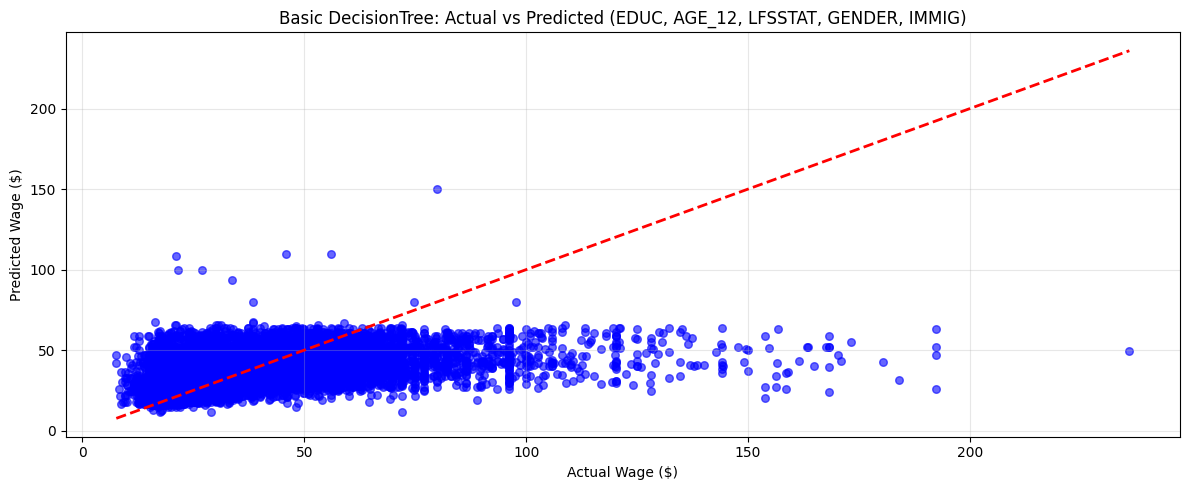

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.474
  AGE_12: 0.355
  LFSSTAT: 0.013
  GENDER: 0.091
  IMMIG: 0.067
Tree depth: 15, Leaves: 798


{'model': DecisionTreeRegressor(max_depth=15, random_state=42),
 'X_test':         EDUC  AGE_12  LFSSTAT  GENDER  IMMIG
 50472      4      60        1       1      3
 59244      4      40        1       1      2
 73258      2      40        1       2      3
 70175      5      40        1       2      2
 36834      2      25        1       1      3
 ...      ...     ...      ...     ...    ...
 14370      2      60        1       2      3
 72812      1      15        1       2      3
 101334     5      60        1       2      3
 74999      4      45        1       1      3
 84072      4      40        1       1      3
 
 [17105 rows x 5 columns],
 'y_test': 50472      26.00
 59244      43.42
 73258      38.46
 70175     110.00
 36834      25.00
            ...  
 14370      41.03
 72812      16.00
 101334     34.22
 74999      52.56
 84072      27.00
 Name: HRLYEARN, Length: 17105, dtype: float64,
 'y_pred': array([40.09359223, 41.00988889, 28.94261905, ..., 40.04880952,
        43.090

In [13]:
# ['EDUC', 'Age', 'Full/Part Time', 'GENDER', 'IMMIG']
features = ['EDUC', 'AGE_12', 'LFSSTAT', 'GENDER', 'IMMIG']
decision_tree(df, features, "HRLYEARN", max_depth=5)
decision_tree(df, features, "HRLYEARN", max_depth=10)
decision_tree(df, features, "HRLYEARN", max_depth=15)

In [14]:
# Display saved results
results_df = pd.read_csv(results_file)

# print column names
print(f"Results columns: {results_df.columns.tolist()}")

print("All Results Summary:")
display_cols = ["Model Name", "Feature Columns", "Mean Error Percentage (%)", "R Square Score", "Root Mean Squared Error (RMSE)"]
print(results_df[display_cols].round(3).to_string(index=False))

Results columns: ['Record Time', 'Train Time (s)', 'Method', 'Model Name', 'Feature Columns', 'Target Column', 'Parameters', 'CV Score (R²)', 'R Square Score', 'Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Error Percentage (%)']
All Results Summary:
  Model Name                      Feature Columns  Mean Error Percentage (%)  R Square Score  Root Mean Squared Error (RMSE)
DecisionTree                               AGE_12                     50.825           0.108                          18.040
DecisionTree                      AGE_12, LFSSTAT                     50.829           0.108                          18.039
DecisionTree                      AGE_12, LFSSTAT                     50.816           0.109                          18.035
DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     47.131           0.232                          16.741
DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     46.9

## Random Forest

In [15]:
def random_forest(df, features, target, max_depth=10, n_estimators=100, model_name="RandomForest"):
    """
    Train and evaluate a Random Forest regression model.
    """
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
    return train_and_evaluate_model(
        df=df, 
        features=features, 
        target=target, 
        model=model, 
        model_name=model_name,
        method="Basic"
    )

Data after preprocessing: 57015 rows



Basic RandomForest with AGE_12:
R² Score: 0.1082
Mean Absolute Error (MAE): $12.7913
Mean Squared Error (MSE): $325.4573
Root Mean Squared Error (RMSE): $18.0404
Mean Error Percentage: 50.81%


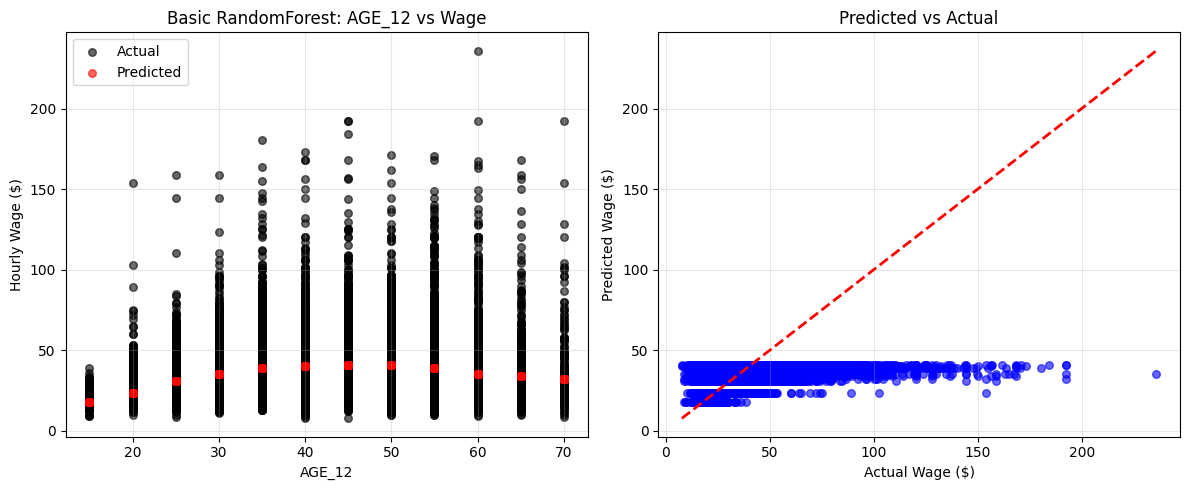

Results saved to reg_results.csv
Number of estimators: 100
Max depth: 10


In [16]:
# Single feature test
result_rf1 = random_forest(df, ["AGE_12"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic RandomForest with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7888
Mean Squared Error (MSE): $325.4134
Root Mean Squared Error (RMSE): $18.0392
Mean Error Percentage: 50.81%

Basic RandomForest with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7888
Mean Squared Error (MSE): $325.4134
Root Mean Squared Error (RMSE): $18.0392
Mean Error Percentage: 50.81%


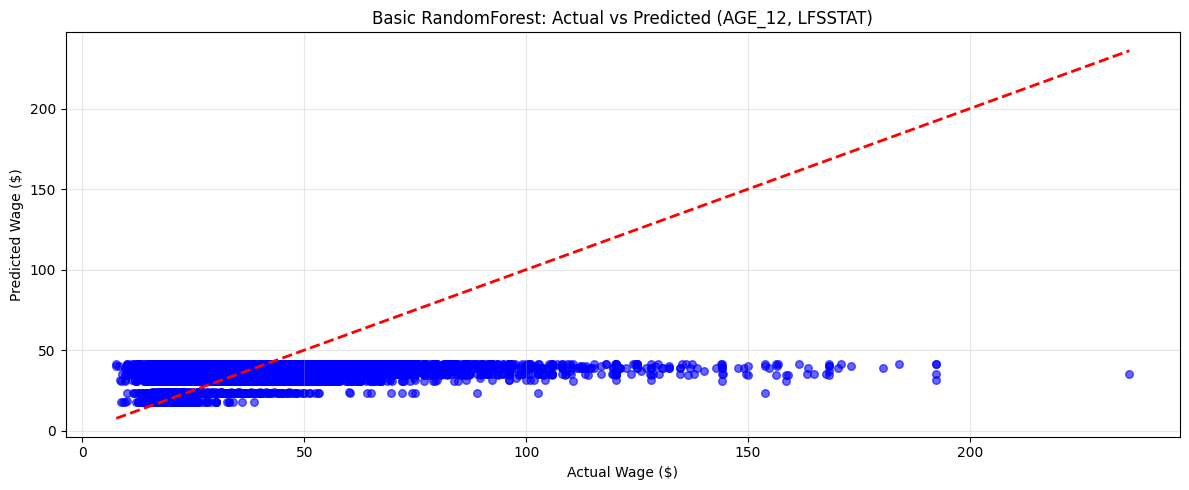

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.993
  LFSSTAT: 0.007
Number of estimators: 100
Max depth: 10


In [17]:
# Multiple features test
result_rf2 = random_forest(df, ["AGE_12", "LFSSTAT"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic RandomForest with AGE_12, LFSSTAT:
R² Score: 0.1088
Mean Absolute Error (MAE): $12.7878
Mean Squared Error (MSE): $325.2353
Root Mean Squared Error (RMSE): $18.0343
Mean Error Percentage: 50.79%

Basic RandomForest with AGE_12, LFSSTAT:
R² Score: 0.1088
Mean Absolute Error (MAE): $12.7878
Mean Squared Error (MSE): $325.2353
Root Mean Squared Error (RMSE): $18.0343
Mean Error Percentage: 50.79%


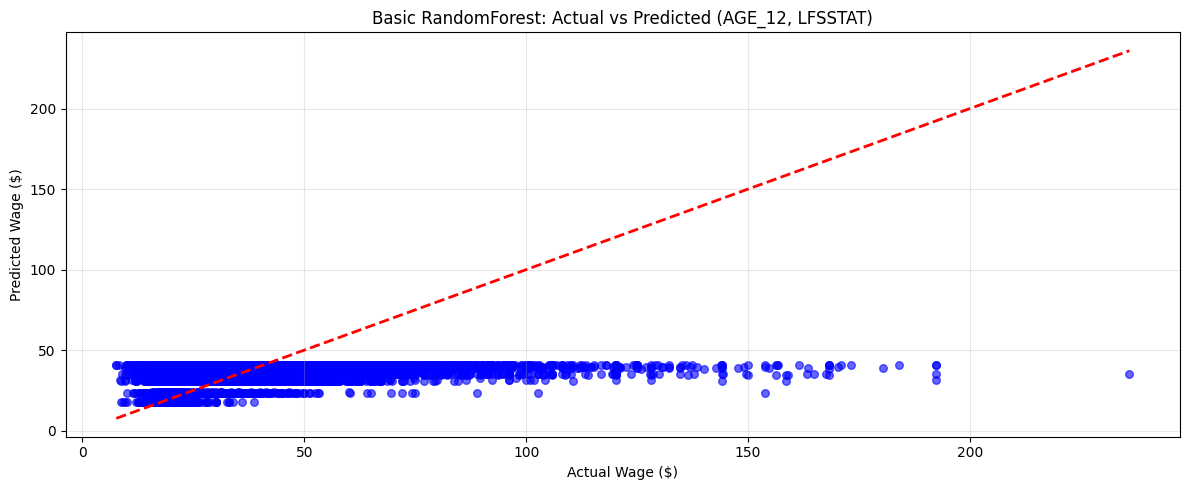

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.995
  LFSSTAT: 0.005
Number of estimators: 50
Max depth: 5


In [18]:
# Test with different parameters
result_rf3 = random_forest(df, ["AGE_12", "LFSSTAT"], "HRLYEARN", 
                          max_depth=5, n_estimators=50)

Data after preprocessing: 57015 rows

Basic RandomForest with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2429
Mean Absolute Error (MAE): $11.2900
Mean Squared Error (MSE): $276.3251
Root Mean Squared Error (RMSE): $16.6230
Mean Error Percentage: 46.81%

Basic RandomForest with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2429
Mean Absolute Error (MAE): $11.2900
Mean Squared Error (MSE): $276.3251
Root Mean Squared Error (RMSE): $16.6230
Mean Error Percentage: 46.81%


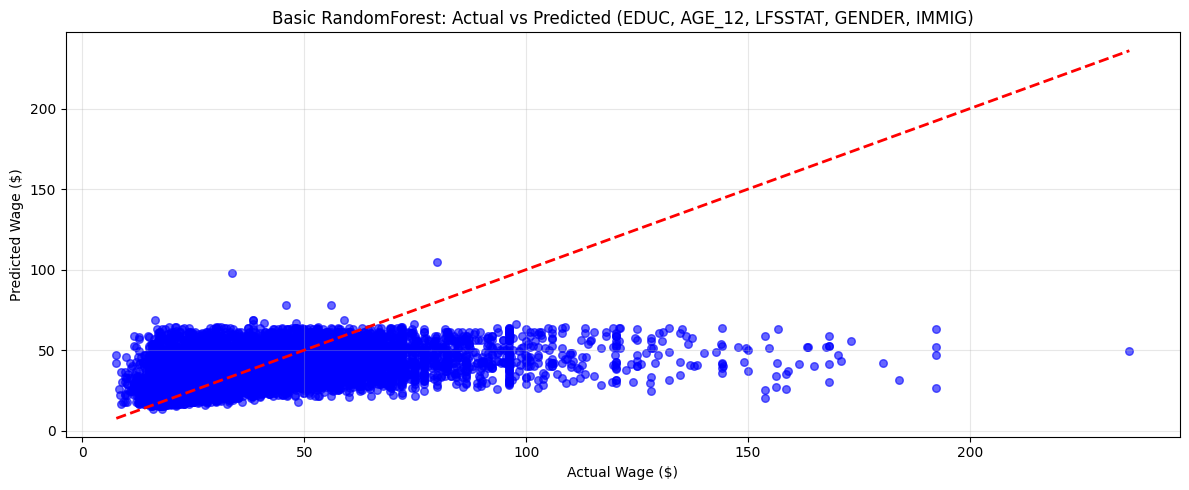

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.463
  AGE_12: 0.357
  LFSSTAT: 0.018
  GENDER: 0.090
  IMMIG: 0.073
Number of estimators: 50
Max depth: 10
Data after preprocessing: 57015 rows

Basic RandomForest with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2428
Mean Absolute Error (MAE): $11.2897
Mean Squared Error (MSE): $276.3309
Root Mean Squared Error (RMSE): $16.6232
Mean Error Percentage: 46.81%

Basic RandomForest with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2428
Mean Absolute Error (MAE): $11.2897
Mean Squared Error (MSE): $276.3309
Root Mean Squared Error (RMSE): $16.6232
Mean Error Percentage: 46.81%


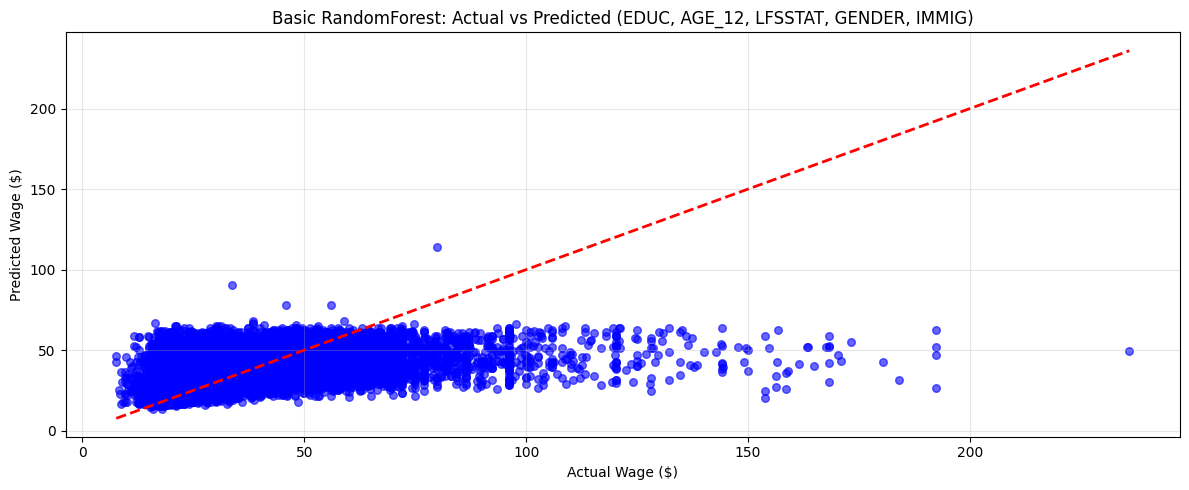

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.463
  AGE_12: 0.357
  LFSSTAT: 0.018
  GENDER: 0.090
  IMMIG: 0.072
Number of estimators: 100
Max depth: 10
Data after preprocessing: 57015 rows

Basic RandomForest with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2386
Mean Absolute Error (MAE): $11.3285
Mean Squared Error (MSE): $277.8896
Root Mean Squared Error (RMSE): $16.6700
Mean Error Percentage: 46.94%

Basic RandomForest with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2386
Mean Absolute Error (MAE): $11.3285
Mean Squared Error (MSE): $277.8896
Root Mean Squared Error (RMSE): $16.6700
Mean Error Percentage: 46.94%


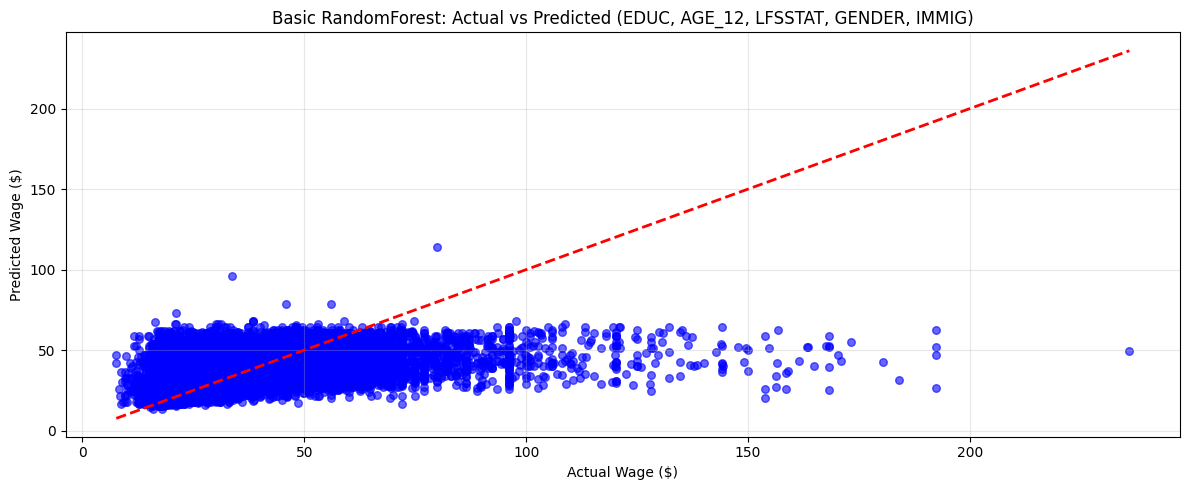

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.457
  AGE_12: 0.361
  LFSSTAT: 0.021
  GENDER: 0.088
  IMMIG: 0.073
Number of estimators: 100
Max depth: 15


{'model': RandomForestRegressor(max_depth=15, random_state=42),
 'X_test':         EDUC  AGE_12  LFSSTAT  GENDER  IMMIG
 50472      4      60        1       1      3
 59244      4      40        1       1      2
 73258      2      40        1       2      3
 70175      5      40        1       2      2
 36834      2      25        1       1      3
 ...      ...     ...      ...     ...    ...
 14370      2      60        1       2      3
 72812      1      15        1       2      3
 101334     5      60        1       2      3
 74999      4      45        1       1      3
 84072      4      40        1       1      3
 
 [17105 rows x 5 columns],
 'y_test': 50472      26.00
 59244      43.42
 73258      38.46
 70175     110.00
 36834      25.00
            ...  
 14370      41.03
 72812      16.00
 101334     34.22
 74999      52.56
 84072      27.00
 Name: HRLYEARN, Length: 17105, dtype: float64,
 'y_pred': array([39.91926922, 40.87712435, 28.94769663, ..., 39.95711458,
        43.138

In [19]:
# Test with multiple features and different n_estimators
features = ['EDUC', 'AGE_12', 'LFSSTAT', 'GENDER', 'IMMIG']
random_forest(df, features, "HRLYEARN", max_depth=10, n_estimators=50)
random_forest(df, features, "HRLYEARN", max_depth=10, n_estimators=100)
random_forest(df, features, "HRLYEARN", max_depth=15, n_estimators=100)

In [20]:
# Display all results comparing Decision Tree vs Random Forest
results_df = pd.read_csv(results_file)
print("Complete Results Summary:")
display_cols = ["Model Name", "Feature Columns", "Mean Error Percentage (%)", "R Square Score", "Root Mean Squared Error (RMSE)"]
print(results_df[display_cols].round(3).to_string(index=False))

Complete Results Summary:
  Model Name                      Feature Columns  Mean Error Percentage (%)  R Square Score  Root Mean Squared Error (RMSE)
DecisionTree                               AGE_12                     50.825           0.108                          18.040
DecisionTree                      AGE_12, LFSSTAT                     50.829           0.108                          18.039
DecisionTree                      AGE_12, LFSSTAT                     50.816           0.109                          18.035
DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     47.131           0.232                          16.741
DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     46.921           0.239                          16.665
DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     47.105           0.234                          16.724
RandomForest                               AGE_12                     50.807           0.108       

## AdaBoost

In [21]:
def ada_boost(df, features, target, n_estimators=50, learning_rate=1.0, model_name="AdaBoost"):
    """
    Train and evaluate an AdaBoost regression model.
    """
    model = AdaBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    return train_and_evaluate_model(
        df=df, 
        features=features, 
        target=target, 
        model=model, 
        model_name=model_name,
        method="Basic"
    )

Data after preprocessing: 57015 rows

Basic AdaBoost with AGE_12:
R² Score: 0.0611
Mean Absolute Error (MAE): $13.8482
Mean Squared Error (MSE): $342.6688
Root Mean Squared Error (RMSE): $18.5113
Mean Error Percentage: 47.44%

Basic AdaBoost with AGE_12:
R² Score: 0.0611
Mean Absolute Error (MAE): $13.8482
Mean Squared Error (MSE): $342.6688
Root Mean Squared Error (RMSE): $18.5113
Mean Error Percentage: 47.44%


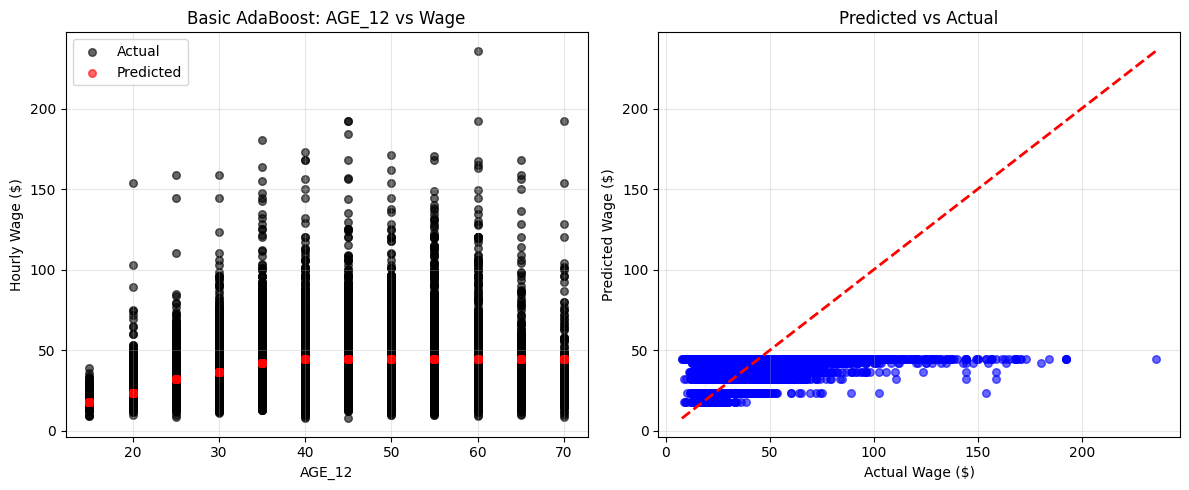

Results saved to reg_results.csv
Number of estimators: 50


In [22]:
# Single feature test
result_ada1 = ada_boost(df, ["AGE_12"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic AdaBoost with AGE_12, LFSSTAT:
R² Score: 0.0613
Mean Absolute Error (MAE): $13.8442
Mean Squared Error (MSE): $342.5844
Root Mean Squared Error (RMSE): $18.5090
Mean Error Percentage: 47.44%


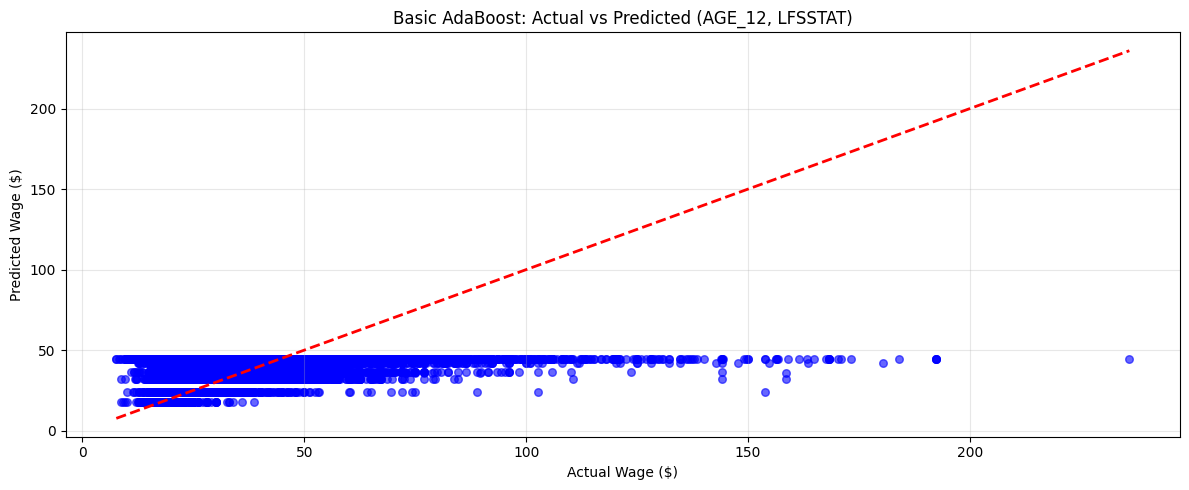

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.994
  LFSSTAT: 0.006
Number of estimators: 50


In [23]:
# Multiple features test
result_ada2 = ada_boost(df, ["AGE_12", "LFSSTAT"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic AdaBoost with AGE_12, LFSSTAT:
R² Score: -0.0094
Mean Absolute Error (MAE): $14.6848
Mean Squared Error (MSE): $368.3727
Root Mean Squared Error (RMSE): $19.1930
Mean Error Percentage: 46.49%


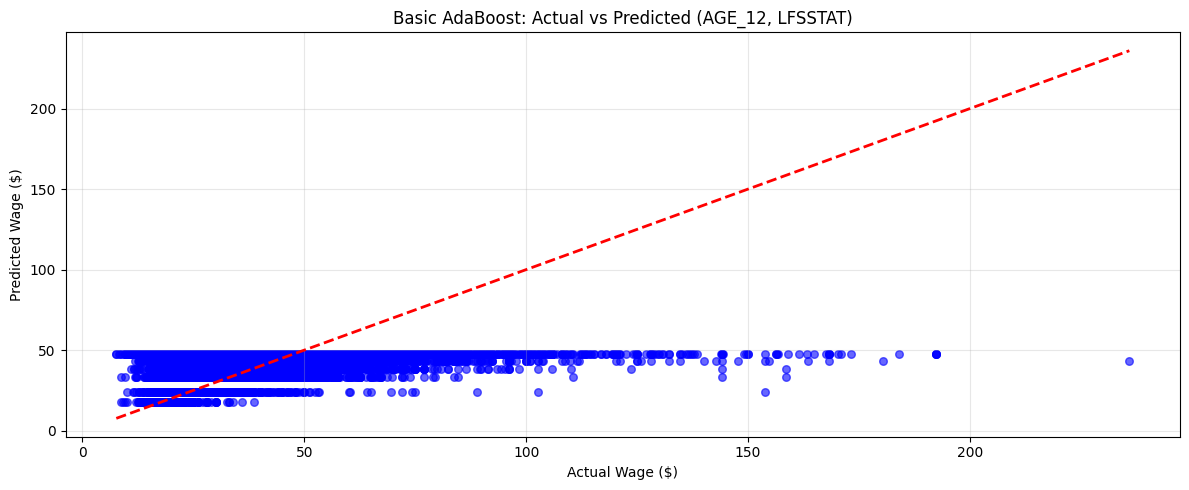

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.993
  LFSSTAT: 0.007
Number of estimators: 100


In [24]:
# Test with different parameters
result_ada3 = ada_boost(df, ["AGE_12", "LFSSTAT"], "HRLYEARN", 
                       n_estimators=100, learning_rate=0.5)

Data after preprocessing: 57015 rows

Basic AdaBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.1312
Mean Absolute Error (MAE): $13.0316
Mean Squared Error (MSE): $317.0574
Root Mean Squared Error (RMSE): $17.8061
Mean Error Percentage: 44.24%

Basic AdaBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.1312
Mean Absolute Error (MAE): $13.0316
Mean Squared Error (MSE): $317.0574
Root Mean Squared Error (RMSE): $17.8061
Mean Error Percentage: 44.24%


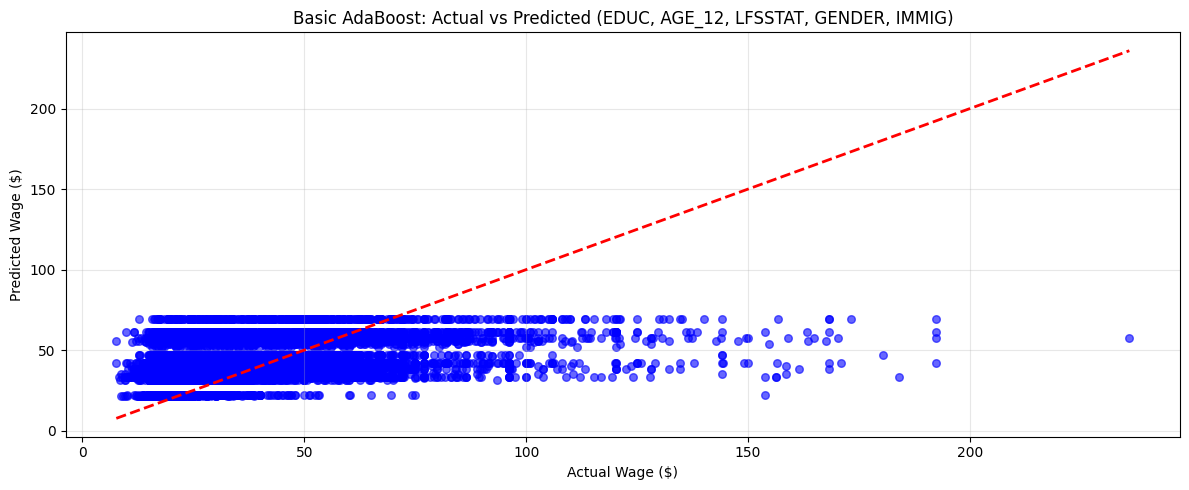

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.521
  AGE_12: 0.375
  LFSSTAT: 0.000
  GENDER: 0.085
  IMMIG: 0.019
Number of estimators: 50
Data after preprocessing: 57015 rows

Basic AdaBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.1572
Mean Absolute Error (MAE): $12.7902
Mean Squared Error (MSE): $307.5913
Root Mean Squared Error (RMSE): $17.5383
Mean Error Percentage: 44.81%

Basic AdaBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.1572
Mean Absolute Error (MAE): $12.7902
Mean Squared Error (MSE): $307.5913
Root Mean Squared Error (RMSE): $17.5383
Mean Error Percentage: 44.81%


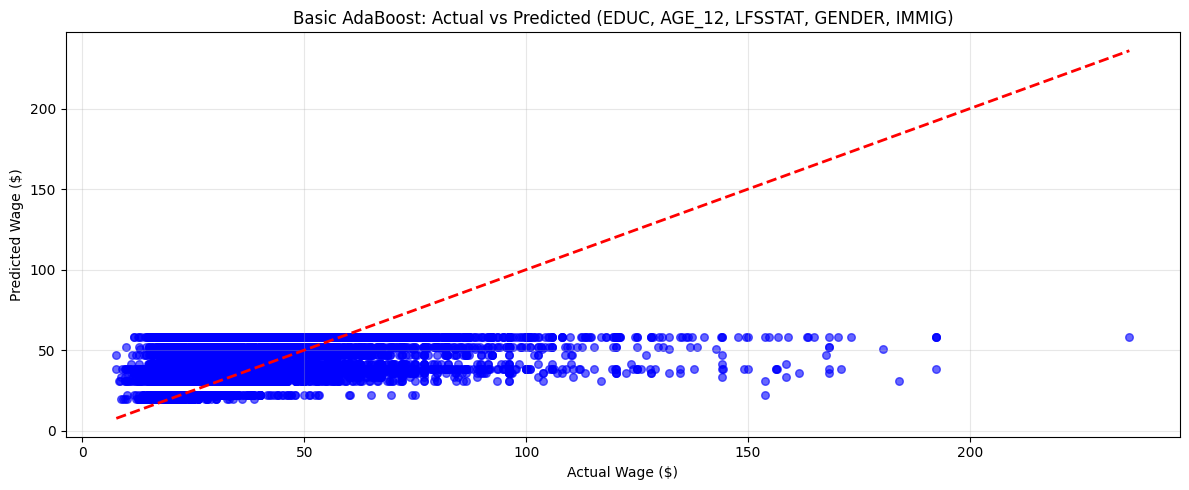

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.520
  AGE_12: 0.382
  LFSSTAT: 0.000
  GENDER: 0.076
  IMMIG: 0.022
Number of estimators: 50
Data after preprocessing: 57015 rows

Basic AdaBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.1572
Mean Absolute Error (MAE): $12.7902
Mean Squared Error (MSE): $307.5913
Root Mean Squared Error (RMSE): $17.5383
Mean Error Percentage: 44.81%

Basic AdaBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.1572
Mean Absolute Error (MAE): $12.7902
Mean Squared Error (MSE): $307.5913
Root Mean Squared Error (RMSE): $17.5383
Mean Error Percentage: 44.81%


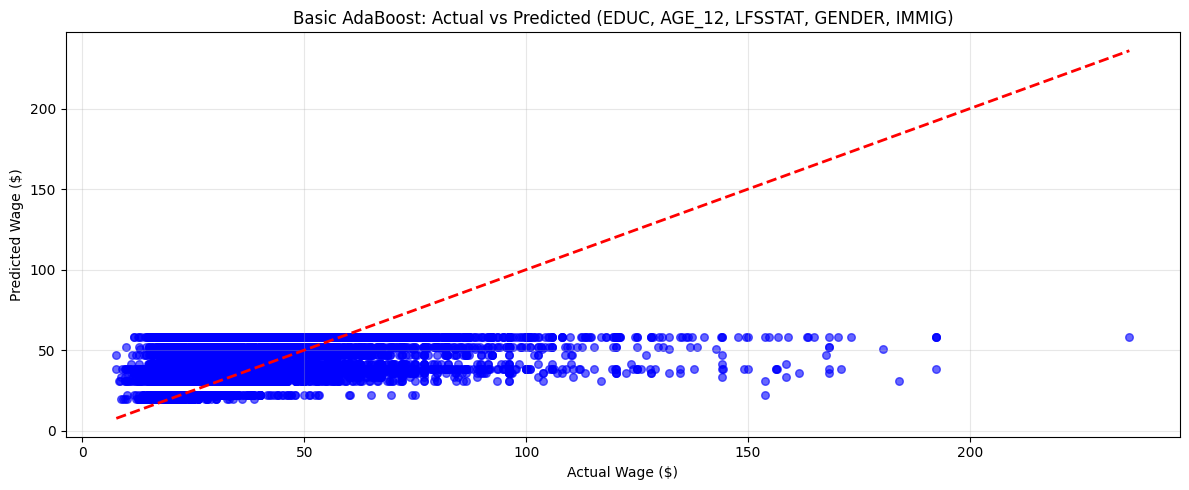

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.520
  AGE_12: 0.382
  LFSSTAT: 0.000
  GENDER: 0.076
  IMMIG: 0.022
Number of estimators: 100


{'model': AdaBoostRegressor(n_estimators=100, random_state=42),
 'X_test':         EDUC  AGE_12  LFSSTAT  GENDER  IMMIG
 50472      4      60        1       1      3
 59244      4      40        1       1      2
 73258      2      40        1       2      3
 70175      5      40        1       2      2
 36834      2      25        1       1      3
 ...      ...     ...      ...     ...    ...
 14370      2      60        1       2      3
 72812      1      15        1       2      3
 101334     5      60        1       2      3
 74999      4      45        1       1      3
 84072      4      40        1       1      3
 
 [17105 rows x 5 columns],
 'y_test': 50472      26.00
 59244      43.42
 73258      38.46
 70175     110.00
 36834      25.00
            ...  
 14370      41.03
 72812      16.00
 101334     34.22
 74999      52.56
 84072      27.00
 Name: HRLYEARN, Length: 17105, dtype: float64,
 'y_pred': array([38.11860227, 38.11860227, 31.01492547, ..., 58.36796793,
        38.118

In [25]:
# Test with multiple features and different learning rates
features = ['EDUC', 'AGE_12', 'LFSSTAT', 'GENDER', 'IMMIG']
ada_boost(df, features, "HRLYEARN", n_estimators=50, learning_rate=0.5)
ada_boost(df, features, "HRLYEARN", n_estimators=50, learning_rate=1.0)
ada_boost(df, features, "HRLYEARN", n_estimators=100, learning_rate=1.0)

In [26]:
# Display all results comparing Decision Tree vs Random Forest vs AdaBoost
results_df = pd.read_csv(results_file)
print("Complete Results Summary (All Models):")
display_cols = ["Model Name", "Feature Columns", "Mean Error Percentage (%)", "R Square Score", "Root Mean Squared Error (RMSE)"]
print(results_df[display_cols].round(3).to_string(index=False))

Complete Results Summary (All Models):
  Model Name                      Feature Columns  Mean Error Percentage (%)  R Square Score  Root Mean Squared Error (RMSE)
DecisionTree                               AGE_12                     50.825           0.108                          18.040
DecisionTree                      AGE_12, LFSSTAT                     50.829           0.108                          18.039
DecisionTree                      AGE_12, LFSSTAT                     50.816           0.109                          18.035
DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     47.131           0.232                          16.741
DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     46.921           0.239                          16.665
DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     47.105           0.234                          16.724
RandomForest                               AGE_12                     50.807          

## Gradient Boosting

In [27]:
def gradient_boosting(df, features, target, n_estimators=100, learning_rate=0.1, max_depth=3, model_name="GradientBoosting"):
    """
    Train and evaluate a Gradient Boosting regression model.
    """
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        random_state=42
    )
    return train_and_evaluate_model(
        df=df, 
        features=features, 
        target=target, 
        model=model, 
        model_name=model_name,
        method="Basic"
    )

Data after preprocessing: 57015 rows

Basic GradientBoosting with AGE_12:
R² Score: 0.1083
Mean Absolute Error (MAE): $12.7885
Mean Squared Error (MSE): $325.4361
Root Mean Squared Error (RMSE): $18.0398
Mean Error Percentage: 50.82%

Basic GradientBoosting with AGE_12:
R² Score: 0.1083
Mean Absolute Error (MAE): $12.7885
Mean Squared Error (MSE): $325.4361
Root Mean Squared Error (RMSE): $18.0398
Mean Error Percentage: 50.82%


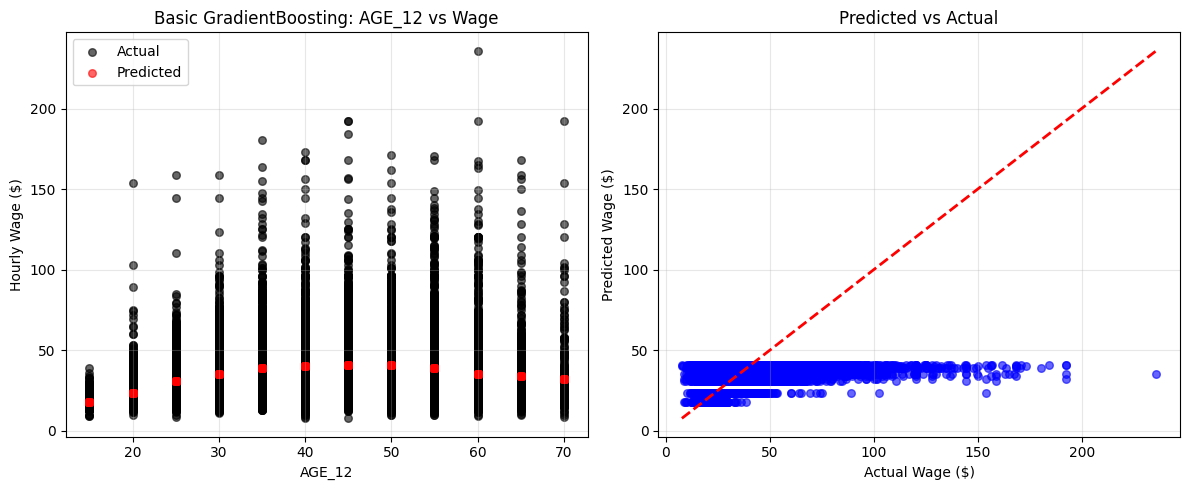

Results saved to reg_results.csv
Number of estimators: 100
Max depth: 3


In [28]:
# Single feature test
result_gb1 = gradient_boosting(df, ["AGE_12"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic GradientBoosting with AGE_12, LFSSTAT:
R² Score: 0.1085
Mean Absolute Error (MAE): $12.7863
Mean Squared Error (MSE): $325.3676
Root Mean Squared Error (RMSE): $18.0379
Mean Error Percentage: 50.83%

Basic GradientBoosting with AGE_12, LFSSTAT:
R² Score: 0.1085
Mean Absolute Error (MAE): $12.7863
Mean Squared Error (MSE): $325.3676
Root Mean Squared Error (RMSE): $18.0379
Mean Error Percentage: 50.83%


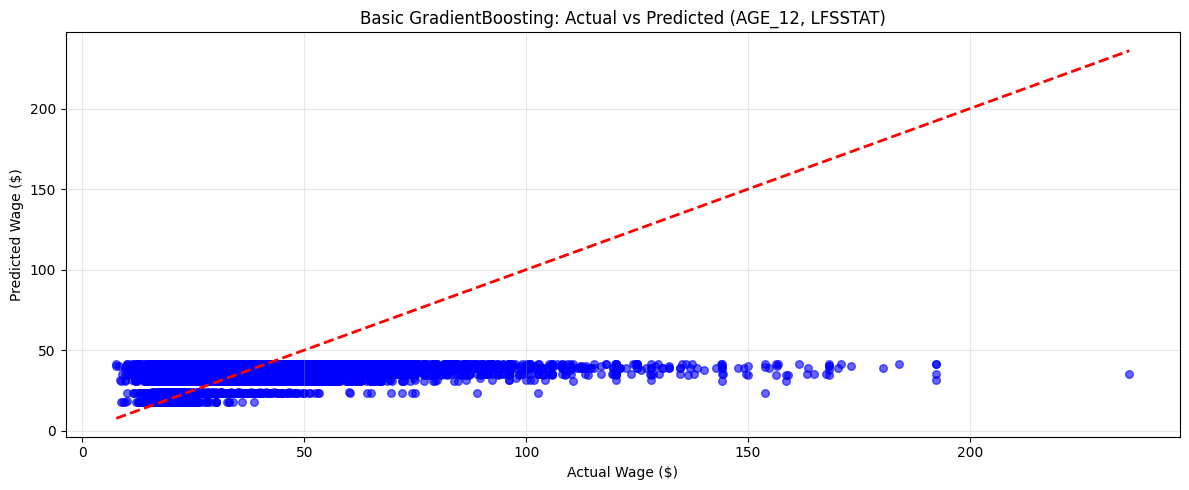

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.997
  LFSSTAT: 0.003
Number of estimators: 100
Max depth: 3


In [29]:
# Multiple features test
result_gb2 = gradient_boosting(df, ["AGE_12", "LFSSTAT"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic GradientBoosting with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7859
Mean Squared Error (MSE): $325.3945
Root Mean Squared Error (RMSE): $18.0387
Mean Error Percentage: 50.83%

Basic GradientBoosting with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7859
Mean Squared Error (MSE): $325.3945
Root Mean Squared Error (RMSE): $18.0387
Mean Error Percentage: 50.83%


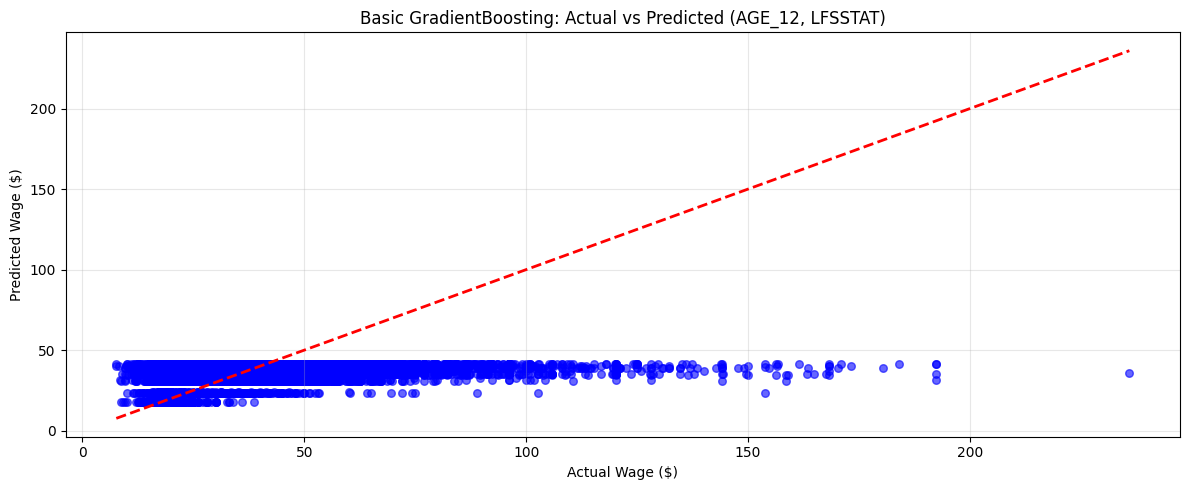

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.994
  LFSSTAT: 0.006
Number of estimators: 200
Max depth: 5


In [30]:
# Test with different parameters
result_gb3 = gradient_boosting(df, ["AGE_12", "LFSSTAT"], "HRLYEARN", 
                              n_estimators=200, learning_rate=0.05, max_depth=5)

Data after preprocessing: 57015 rows

Basic GradientBoosting with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2477
Mean Absolute Error (MAE): $11.3136
Mean Squared Error (MSE): $274.5588
Root Mean Squared Error (RMSE): $16.5698
Mean Error Percentage: 46.68%

Basic GradientBoosting with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2477
Mean Absolute Error (MAE): $11.3136
Mean Squared Error (MSE): $274.5588
Root Mean Squared Error (RMSE): $16.5698
Mean Error Percentage: 46.68%


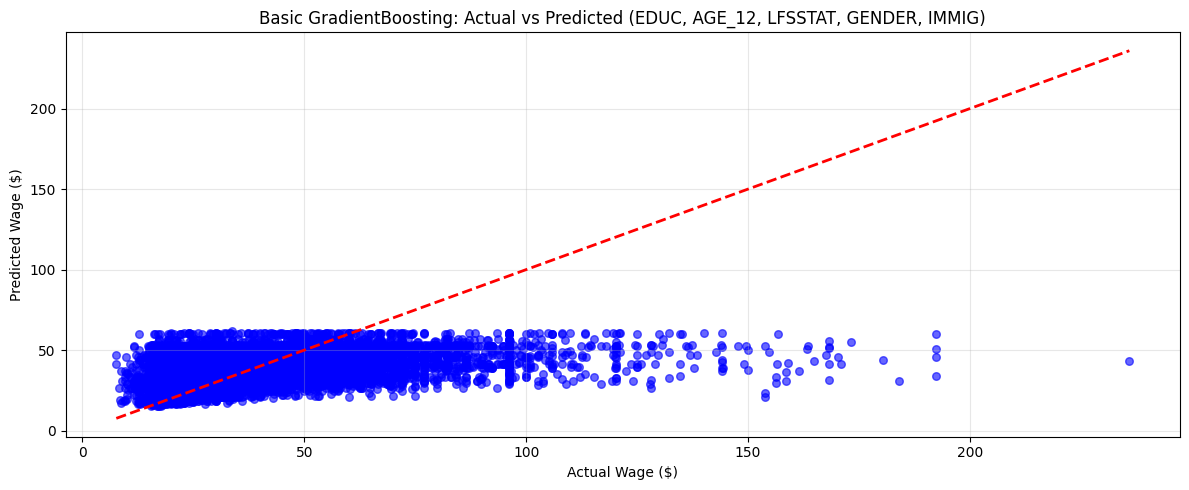

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.513
  AGE_12: 0.324
  LFSSTAT: 0.001
  GENDER: 0.098
  IMMIG: 0.064
Number of estimators: 100
Max depth: 3
Data after preprocessing: 57015 rows

Basic GradientBoosting with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2485
Mean Absolute Error (MAE): $11.2692
Mean Squared Error (MSE): $274.2651
Root Mean Squared Error (RMSE): $16.5610
Mean Error Percentage: 46.66%

Basic GradientBoosting with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2485
Mean Absolute Error (MAE): $11.2692
Mean Squared Error (MSE): $274.2651
Root Mean Squared Error (RMSE): $16.5610
Mean Error Percentage: 46.66%


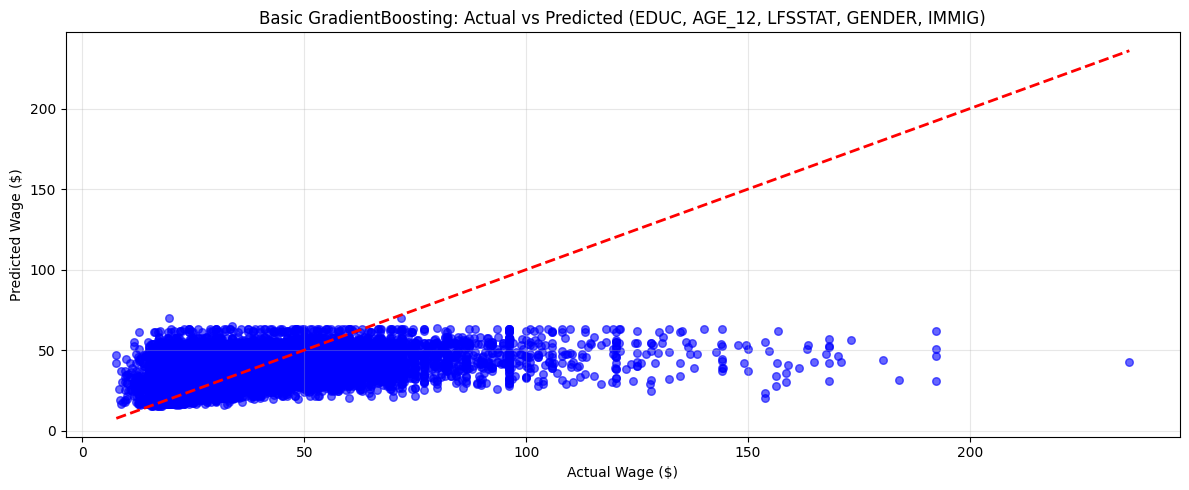

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.510
  AGE_12: 0.325
  LFSSTAT: 0.003
  GENDER: 0.097
  IMMIG: 0.065
Number of estimators: 100
Max depth: 3
Data after preprocessing: 57015 rows

Basic GradientBoosting with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2442
Mean Absolute Error (MAE): $11.2794
Mean Squared Error (MSE): $275.8188
Root Mean Squared Error (RMSE): $16.6078
Mean Error Percentage: 46.77%

Basic GradientBoosting with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2442
Mean Absolute Error (MAE): $11.2794
Mean Squared Error (MSE): $275.8188
Root Mean Squared Error (RMSE): $16.6078
Mean Error Percentage: 46.77%


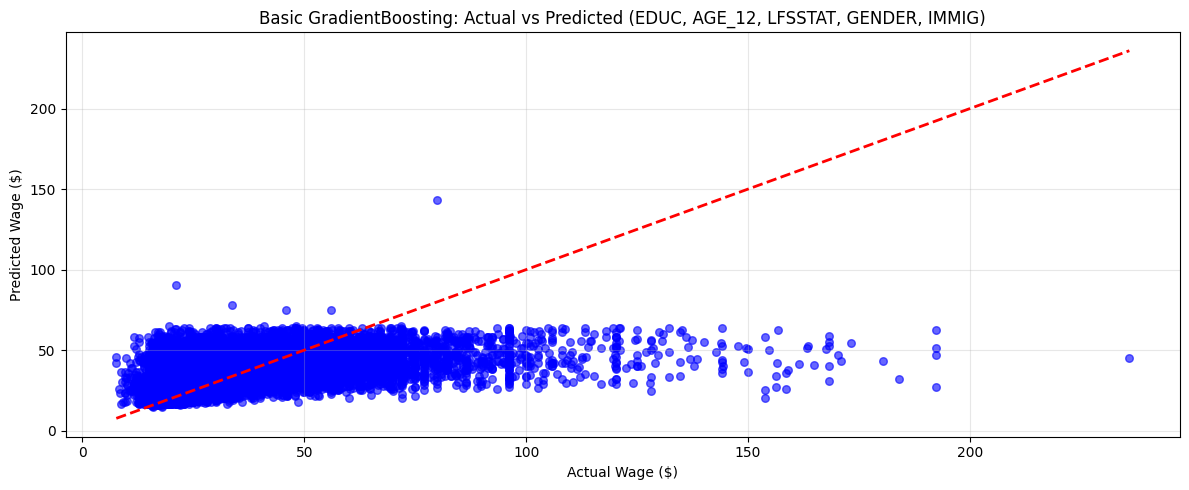

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.483
  AGE_12: 0.340
  LFSSTAT: 0.009
  GENDER: 0.099
  IMMIG: 0.070
Number of estimators: 200
Max depth: 5


{'model': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42),
 'X_test':         EDUC  AGE_12  LFSSTAT  GENDER  IMMIG
 50472      4      60        1       1      3
 59244      4      40        1       1      2
 73258      2      40        1       2      3
 70175      5      40        1       2      2
 36834      2      25        1       1      3
 ...      ...     ...      ...     ...    ...
 14370      2      60        1       2      3
 72812      1      15        1       2      3
 101334     5      60        1       2      3
 74999      4      45        1       1      3
 84072      4      40        1       1      3
 
 [17105 rows x 5 columns],
 'y_test': 50472      26.00
 59244      43.42
 73258      38.46
 70175     110.00
 36834      25.00
            ...  
 14370      41.03
 72812      16.00
 101334     34.22
 74999      52.56
 84072      27.00
 Name: HRLYEARN, Length: 17105, dtype: float64,
 'y_pred': array([39.88002031, 39.42995779, 29.00705282, ..., 40.672

In [31]:
# Test with multiple features and different learning rates
features = ['EDUC', 'AGE_12', 'LFSSTAT', 'GENDER', 'IMMIG']
gradient_boosting(df, features, "HRLYEARN", n_estimators=100, learning_rate=0.05, max_depth=3)
gradient_boosting(df, features, "HRLYEARN", n_estimators=100, learning_rate=0.1, max_depth=3)
gradient_boosting(df, features, "HRLYEARN", n_estimators=200, learning_rate=0.1, max_depth=5)

In [32]:
# Display all results comparing all models
results_df = pd.read_csv(results_file)
print("Complete Results Summary (All Models):")
display_cols = ["Model Name", "Feature Columns", "Mean Error Percentage (%)", "R Square Score", "Root Mean Squared Error (RMSE)"]
print(results_df[display_cols].round(3).to_string(index=False))

Complete Results Summary (All Models):
      Model Name                      Feature Columns  Mean Error Percentage (%)  R Square Score  Root Mean Squared Error (RMSE)
    DecisionTree                               AGE_12                     50.825           0.108                          18.040
    DecisionTree                      AGE_12, LFSSTAT                     50.829           0.108                          18.039
    DecisionTree                      AGE_12, LFSSTAT                     50.816           0.109                          18.035
    DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     47.131           0.232                          16.741
    DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     46.921           0.239                          16.665
    DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     47.105           0.234                          16.724
    RandomForest                               AGE_12     

## XGBoost

In [33]:
def xgboost_regression(df, features, target, n_estimators=100, learning_rate=0.1, max_depth=6, model_name="XGBoost"):
    """
    Train and evaluate an XGBoost regression model.
    """
    model = xgb.XGBRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        random_state=42
    )
    return train_and_evaluate_model(
        df=df, 
        features=features, 
        target=target, 
        model=model, 
        model_name=model_name,
        method="Basic"
    )

Data after preprocessing: 57015 rows

Basic XGBoost with AGE_12:
R² Score: 0.1083
Mean Absolute Error (MAE): $12.7885
Mean Squared Error (MSE): $325.4362
Root Mean Squared Error (RMSE): $18.0398
Mean Error Percentage: 50.82%

Basic XGBoost with AGE_12:
R² Score: 0.1083
Mean Absolute Error (MAE): $12.7885
Mean Squared Error (MSE): $325.4362
Root Mean Squared Error (RMSE): $18.0398
Mean Error Percentage: 50.82%


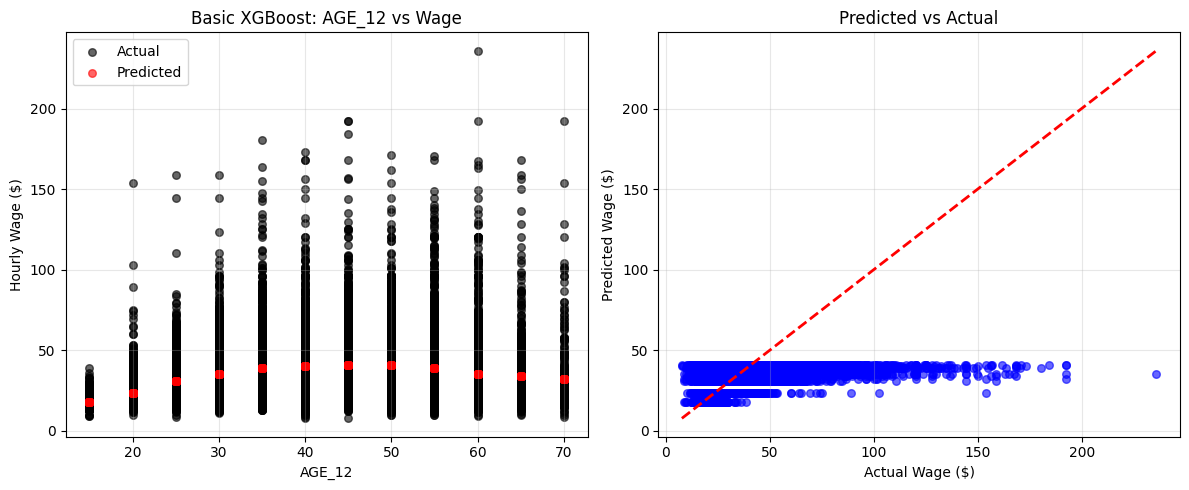

Results saved to reg_results.csv
Number of estimators: 100
Max depth: 6


In [34]:
# Single feature test
result_xgb1 = xgboost_regression(df, ["AGE_12"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic XGBoost with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7859
Mean Squared Error (MSE): $325.3944
Root Mean Squared Error (RMSE): $18.0387
Mean Error Percentage: 50.83%


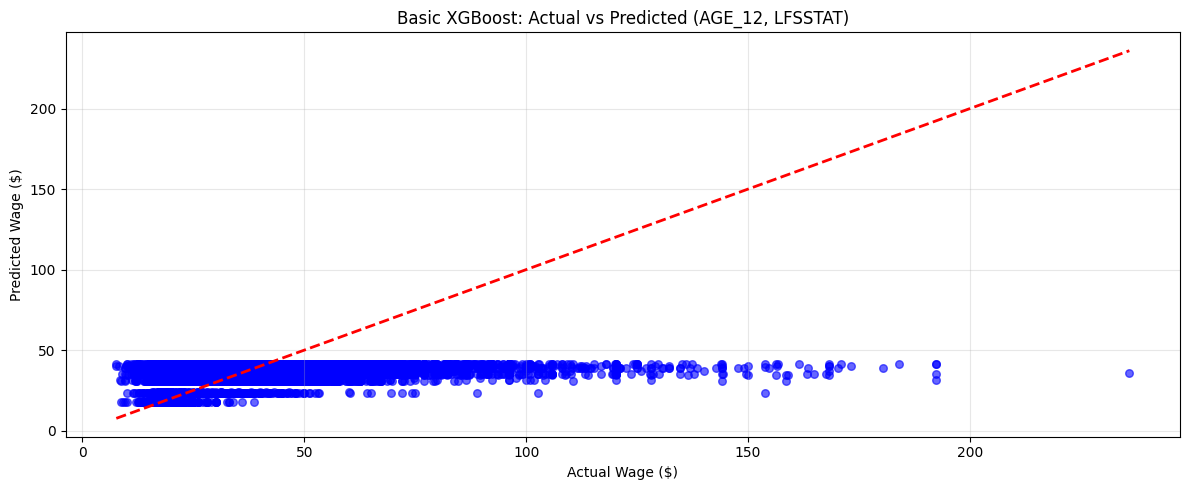

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.992
  LFSSTAT: 0.008
Number of estimators: 100
Max depth: 6


In [35]:
# Multiple features test
result_xgb2 = xgboost_regression(df, ["AGE_12", "LFSSTAT"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic XGBoost with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7859
Mean Squared Error (MSE): $325.3943
Root Mean Squared Error (RMSE): $18.0387
Mean Error Percentage: 50.83%

Basic XGBoost with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7859
Mean Squared Error (MSE): $325.3943
Root Mean Squared Error (RMSE): $18.0387
Mean Error Percentage: 50.83%


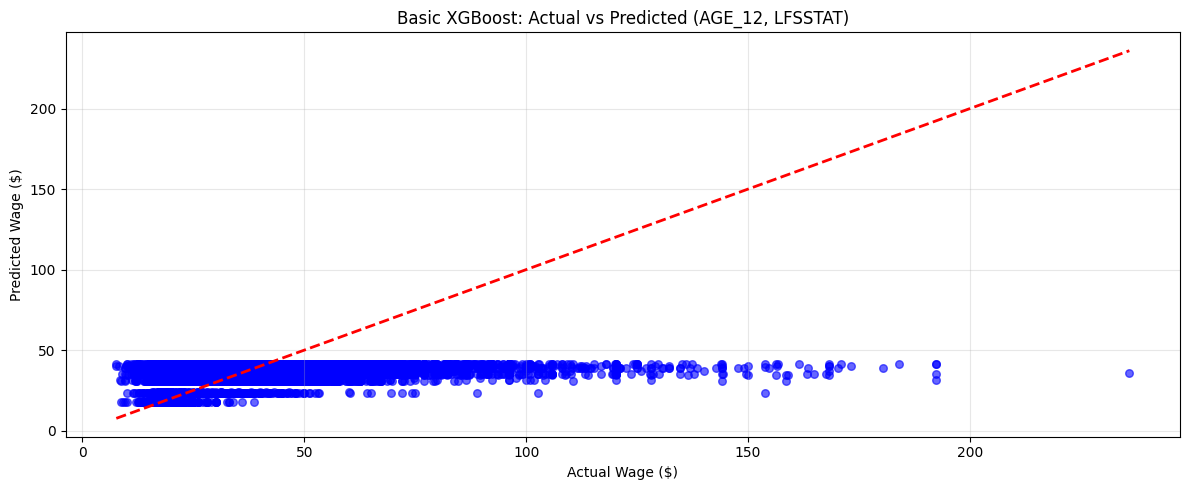

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 0.991
  LFSSTAT: 0.009
Number of estimators: 200
Max depth: 8


In [36]:
# Test with different parameters
result_xgb3 = xgboost_regression(df, ["AGE_12", "LFSSTAT"], "HRLYEARN", 
                                n_estimators=200, learning_rate=0.05, max_depth=8)

Data after preprocessing: 57015 rows

Basic XGBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2475
Mean Absolute Error (MAE): $11.2626
Mean Squared Error (MSE): $274.6455
Root Mean Squared Error (RMSE): $16.5724
Mean Error Percentage: 46.67%


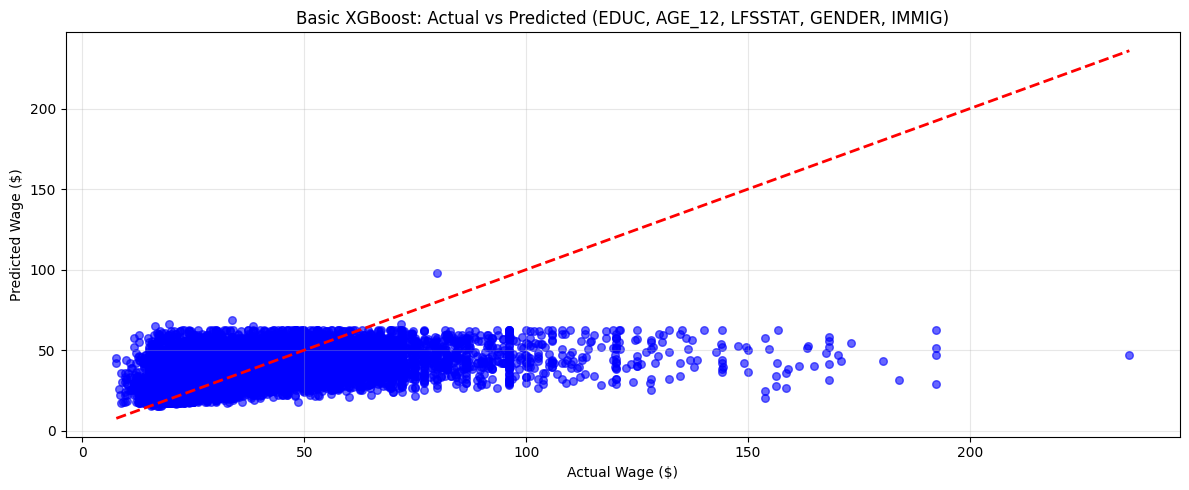

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.543
  AGE_12: 0.241
  LFSSTAT: 0.017
  GENDER: 0.129
  IMMIG: 0.071
Number of estimators: 100
Max depth: 6
Data after preprocessing: 57015 rows

Basic XGBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2447
Mean Absolute Error (MAE): $11.2791
Mean Squared Error (MSE): $275.6553
Root Mean Squared Error (RMSE): $16.6029
Mean Error Percentage: 46.75%


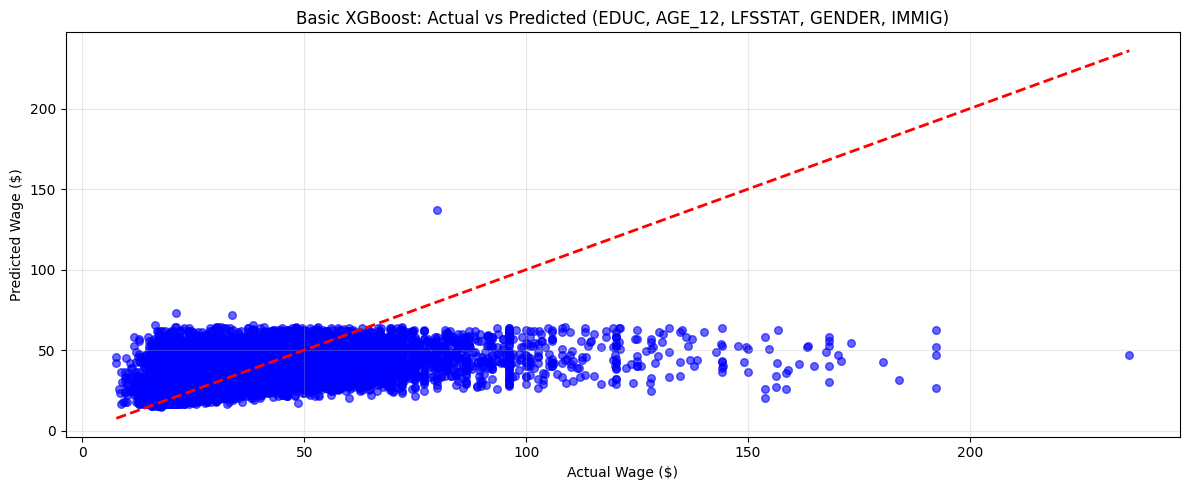

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.493
  AGE_12: 0.262
  LFSSTAT: 0.022
  GENDER: 0.144
  IMMIG: 0.079
Number of estimators: 100
Max depth: 6
Data after preprocessing: 57015 rows

Basic XGBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2362
Mean Absolute Error (MAE): $11.3365
Mean Squared Error (MSE): $278.7394
Root Mean Squared Error (RMSE): $16.6955
Mean Error Percentage: 47.03%

Basic XGBoost with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2362
Mean Absolute Error (MAE): $11.3365
Mean Squared Error (MSE): $278.7394
Root Mean Squared Error (RMSE): $16.6955
Mean Error Percentage: 47.03%


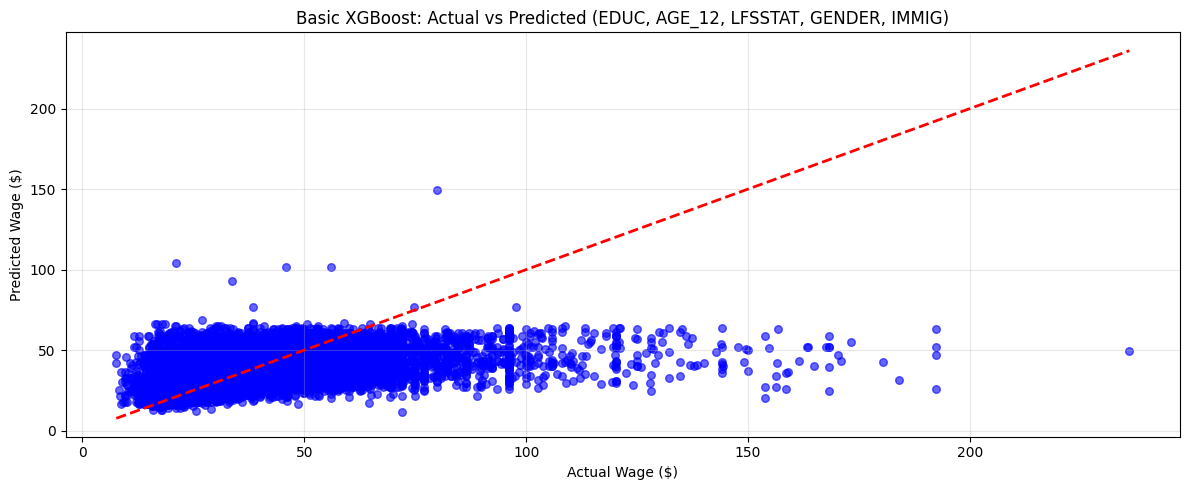

Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.496
  AGE_12: 0.248
  LFSSTAT: 0.022
  GENDER: 0.152
  IMMIG: 0.082
Number of estimators: 200
Max depth: 8


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...),
 'X_test':         EDUC  AGE_12  LFSSTAT  GENDER  IMMIG
 50472      4      60        1       1      3
 59244      4      40        1       1      2
 73258      2      40        1       2      3
 70175      5      40        1       2  

In [37]:
# Test with multiple features and different learning rates
features = ['EDUC', 'AGE_12', 'LFSSTAT', 'GENDER', 'IMMIG']
xgboost_regression(df, features, "HRLYEARN", n_estimators=100, learning_rate=0.05, max_depth=6)
xgboost_regression(df, features, "HRLYEARN", n_estimators=100, learning_rate=0.1, max_depth=6)
xgboost_regression(df, features, "HRLYEARN", n_estimators=200, learning_rate=0.1, max_depth=8)

In [38]:
# Display all results comparing all models including XGBoost
results_df = pd.read_csv(results_file)
print("Complete Results Summary (All Models including XGBoost):")
display_cols = ["Model Name", "Feature Columns", "Mean Error Percentage (%)", "R Square Score", "Root Mean Squared Error (RMSE)"]
print(results_df[display_cols].round(3).to_string(index=False))

Complete Results Summary (All Models including XGBoost):
      Model Name                      Feature Columns  Mean Error Percentage (%)  R Square Score  Root Mean Squared Error (RMSE)
    DecisionTree                               AGE_12                     50.825           0.108                          18.040
    DecisionTree                      AGE_12, LFSSTAT                     50.829           0.108                          18.039
    DecisionTree                      AGE_12, LFSSTAT                     50.816           0.109                          18.035
    DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     47.131           0.232                          16.741
    DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     46.921           0.239                          16.665
    DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     47.105           0.234                          16.724
    RandomForest                        

## LightGBM

In [39]:
def lightgbm_regression(df, features, target, n_estimators=100, learning_rate=0.1, max_depth=-1, model_name="LightGBM"):
    """
    Train and evaluate a LightGBM regression model.
    """
    model = lgb.LGBMRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        random_state=42, 
        verbose=-1
    )
    return train_and_evaluate_model(
        df=df, 
        features=features, 
        target=target, 
        model=model, 
        model_name=model_name,
        method="Basic"
    )

Data after preprocessing: 57015 rows

Basic LightGBM with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7859
Mean Squared Error (MSE): $325.3943
Root Mean Squared Error (RMSE): $18.0387
Mean Error Percentage: 50.83%

Basic LightGBM with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7859
Mean Squared Error (MSE): $325.3943
Root Mean Squared Error (RMSE): $18.0387
Mean Error Percentage: 50.83%


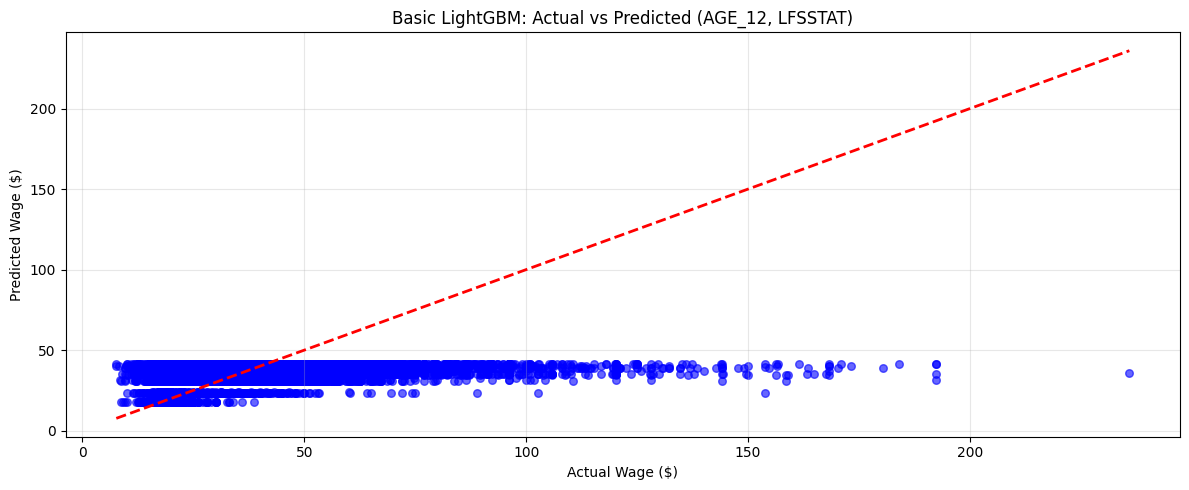

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 2600.000
  LFSSTAT: 2000.000
Number of estimators: 200
Max depth: 8


In [40]:
# Test with different parameters
result_lgb3 = lightgbm_regression(df, ["AGE_12", "LFSSTAT"], "HRLYEARN", 
                                 n_estimators=200, learning_rate=0.05, max_depth=8)

Data after preprocessing: 57015 rows

Basic LightGBM with AGE_12, LFSSTAT:
R² Score: 0.1084
Mean Absolute Error (MAE): $12.7859
Mean Squared Error (MSE): $325.3943
Root Mean Squared Error (RMSE): $18.0387
Mean Error Percentage: 50.83%


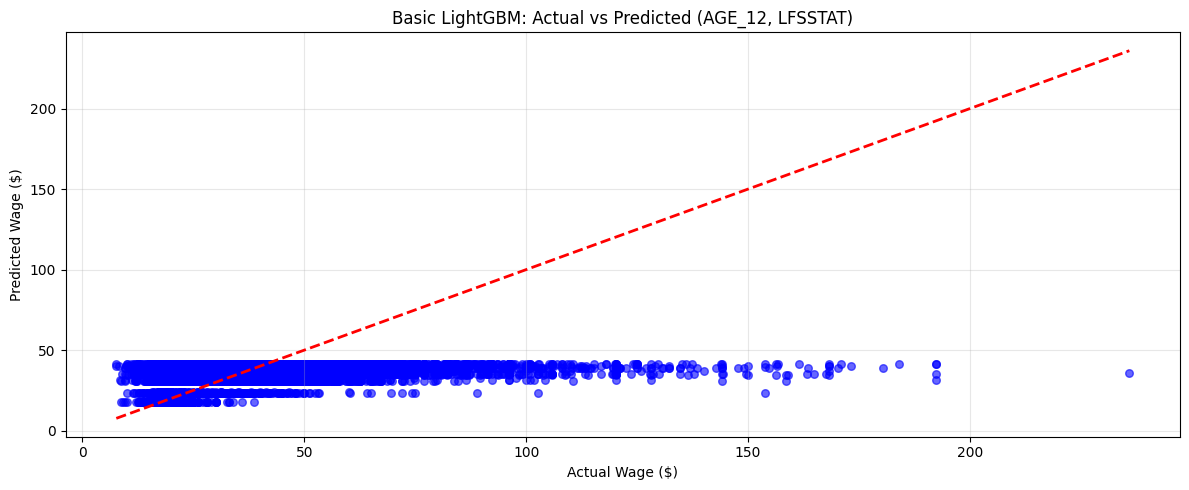

Results saved to reg_results.csv

Feature Importance:
  AGE_12: 1300.000
  LFSSTAT: 1000.000
Number of estimators: 100
Max depth: -1


In [41]:
# Multiple features test
result_lgb2 = lightgbm_regression(df, ["AGE_12", "LFSSTAT"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic LightGBM with AGE_12:
R² Score: 0.1083
Mean Absolute Error (MAE): $12.7885
Mean Squared Error (MSE): $325.4362
Root Mean Squared Error (RMSE): $18.0398
Mean Error Percentage: 50.82%

Basic LightGBM with AGE_12:
R² Score: 0.1083
Mean Absolute Error (MAE): $12.7885
Mean Squared Error (MSE): $325.4362
Root Mean Squared Error (RMSE): $18.0398
Mean Error Percentage: 50.82%


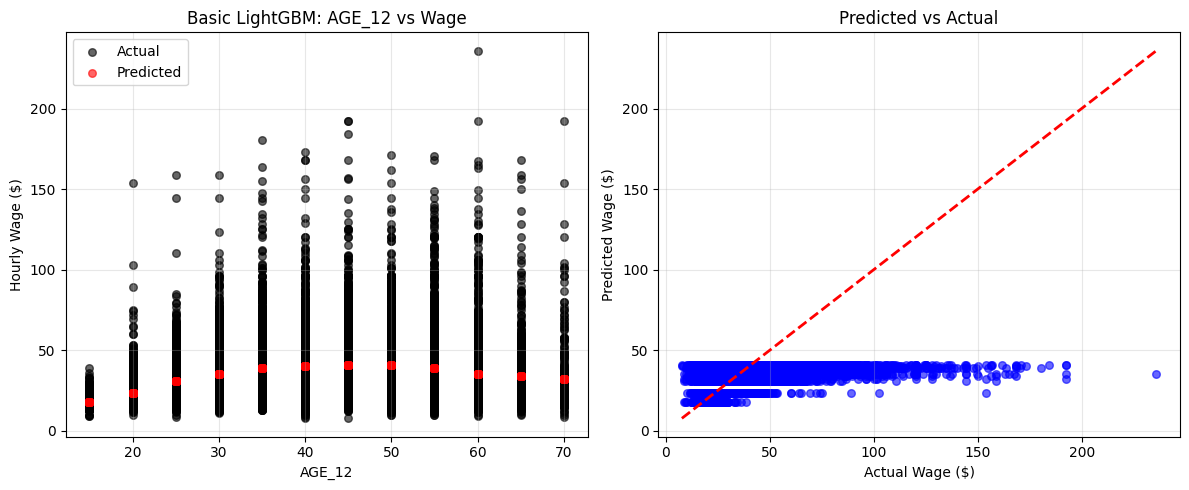

Results saved to reg_results.csv
Number of estimators: 100
Max depth: -1


In [42]:
# Single feature test
result_lgb1 = lightgbm_regression(df, ["AGE_12"], "HRLYEARN")

Data after preprocessing: 57015 rows

Basic LightGBM with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2473
Mean Absolute Error (MAE): $11.2672
Mean Squared Error (MSE): $274.6909
Root Mean Squared Error (RMSE): $16.5738
Mean Error Percentage: 46.68%


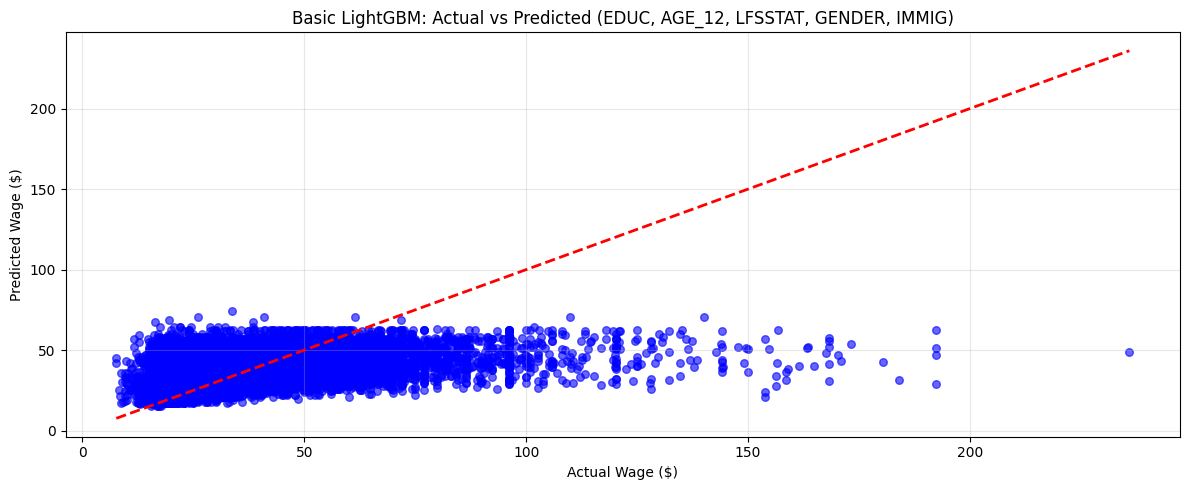

Results saved to reg_results.csv

Feature Importance:
  EDUC: 575.000
  AGE_12: 1282.000
  LFSSTAT: 191.000
  GENDER: 416.000
  IMMIG: 536.000
Number of estimators: 100
Max depth: 6
Data after preprocessing: 57015 rows

Basic LightGBM with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2454
Mean Absolute Error (MAE): $11.2730
Mean Squared Error (MSE): $275.4145
Root Mean Squared Error (RMSE): $16.5956
Mean Error Percentage: 46.74%

Basic LightGBM with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2454
Mean Absolute Error (MAE): $11.2730
Mean Squared Error (MSE): $275.4145
Root Mean Squared Error (RMSE): $16.5956
Mean Error Percentage: 46.74%


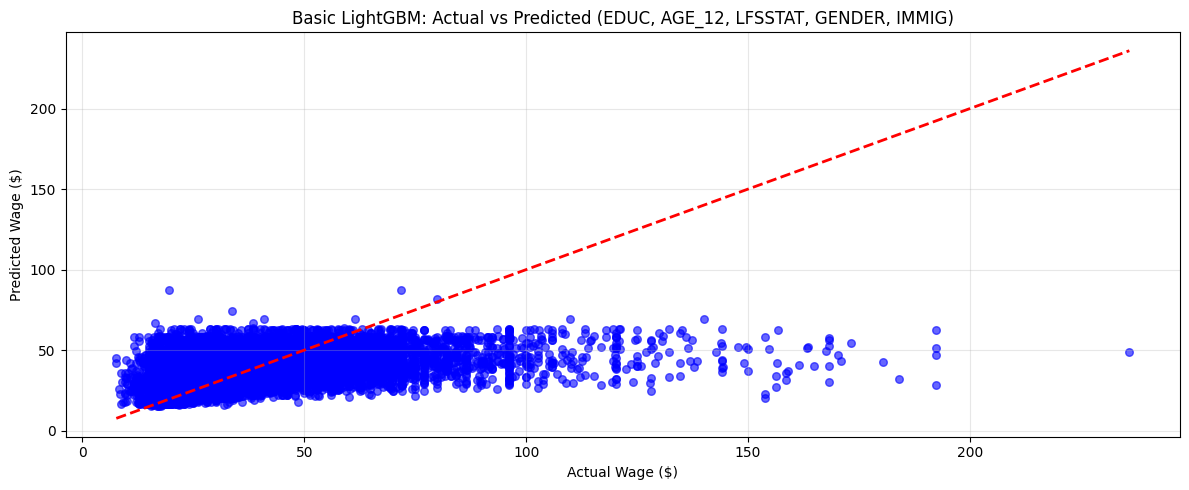

Results saved to reg_results.csv

Feature Importance:
  EDUC: 728.000
  AGE_12: 1254.000
  LFSSTAT: 230.000
  GENDER: 345.000
  IMMIG: 443.000
Number of estimators: 100
Max depth: 6
Data after preprocessing: 57015 rows

Basic LightGBM with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2431
Mean Absolute Error (MAE): $11.2837
Mean Squared Error (MSE): $276.2260
Root Mean Squared Error (RMSE): $16.6200
Mean Error Percentage: 46.80%

Basic LightGBM with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
R² Score: 0.2431
Mean Absolute Error (MAE): $11.2837
Mean Squared Error (MSE): $276.2260
Root Mean Squared Error (RMSE): $16.6200
Mean Error Percentage: 46.80%


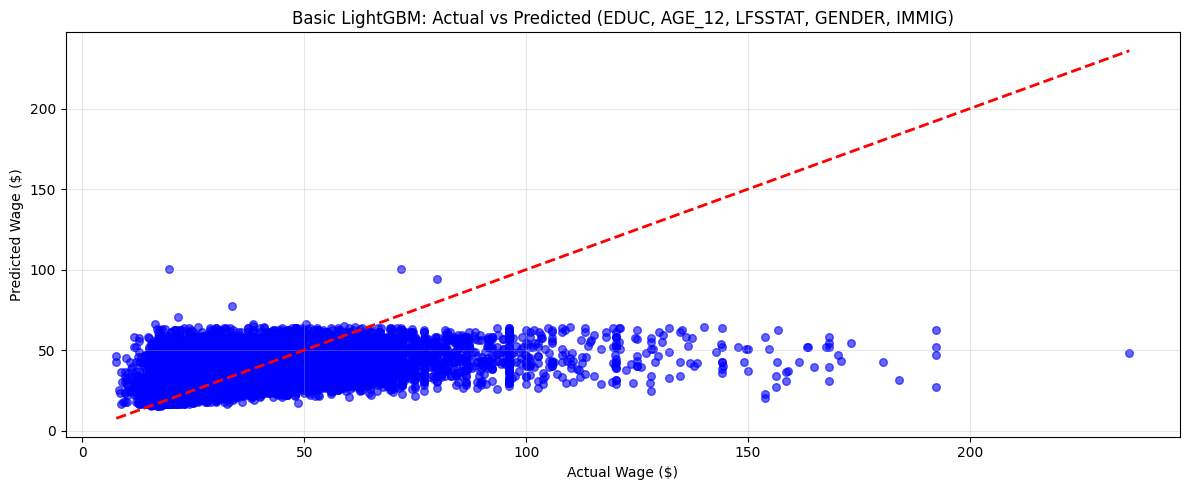

Results saved to reg_results.csv

Feature Importance:
  EDUC: 1465.000
  AGE_12: 2336.000
  LFSSTAT: 390.000
  GENDER: 789.000
  IMMIG: 1020.000
Number of estimators: 200
Max depth: 8


{'model': LGBMRegressor(max_depth=8, n_estimators=200, random_state=42, verbose=-1),
 'X_test':         EDUC  AGE_12  LFSSTAT  GENDER  IMMIG
 50472      4      60        1       1      3
 59244      4      40        1       1      2
 73258      2      40        1       2      3
 70175      5      40        1       2      2
 36834      2      25        1       1      3
 ...      ...     ...      ...     ...    ...
 14370      2      60        1       2      3
 72812      1      15        1       2      3
 101334     5      60        1       2      3
 74999      4      45        1       1      3
 84072      4      40        1       1      3
 
 [17105 rows x 5 columns],
 'y_test': 50472      26.00
 59244      43.42
 73258      38.46
 70175     110.00
 36834      25.00
            ...  
 14370      41.03
 72812      16.00
 101334     34.22
 74999      52.56
 84072      27.00
 Name: HRLYEARN, Length: 17105, dtype: float64,
 'y_pred': array([39.99219837, 39.9372023 , 28.73748713, ..., 39.831

In [43]:
# Test with multiple features and different learning rates
features = ['EDUC', 'AGE_12', 'LFSSTAT', 'GENDER', 'IMMIG']
lightgbm_regression(df, features, "HRLYEARN", n_estimators=100, learning_rate=0.05, max_depth=6)
lightgbm_regression(df, features, "HRLYEARN", n_estimators=100, learning_rate=0.1, max_depth=6)
lightgbm_regression(df, features, "HRLYEARN", n_estimators=200, learning_rate=0.1, max_depth=8)

In [44]:
# Display all results comparing all models including LightGBM
results_df = pd.read_csv(results_file)
print("Complete Results Summary (All Models including LightGBM):")
display_cols = ["Model Name", "Feature Columns", "Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "R Square Score"]
print(results_df[display_cols].round(3).to_string(index=False))

Complete Results Summary (All Models including LightGBM):
      Model Name                      Feature Columns  Mean Absolute Error (MAE)  Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  R Square Score
    DecisionTree                               AGE_12                     12.788                   325.436                          18.040           0.108
    DecisionTree                      AGE_12, LFSSTAT                     12.786                   325.394                          18.039           0.108
    DecisionTree                      AGE_12, LFSSTAT                     12.784                   325.261                          18.035           0.109
    DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     11.456                   280.249                          16.741           0.232
    DecisionTree EDUC, AGE_12, LFSSTAT, GENDER, IMMIG                     11.311                   277.727                          16.665           0.239
    Decision

## Manual Tuning

Manual tuning involves systematically testing different parameter combinations to find the optimal settings for a model. We'll focus on Random Forest as it's one of the most robust and interpretable ensemble methods, testing key parameters that significantly impact model performance.

In [45]:
def manual_hyperparameter_tuning(df, features, target):
    """
    Manually tune hyperparameters for Random Forest regression.
    Testing different combinations of n_estimators and max_depth.
    """
    print("=== Manual Hyperparameter Tuning for Random Forest ===")
    
    # Define parameter combinations to test
    param_sets = [
        {'n_estimators': 50, 'max_depth': 10, 'random_state': 42},
        {'n_estimators': 100, 'max_depth': 15, 'random_state': 42},
        {'n_estimators': 200, 'max_depth': 20, 'random_state': 42},
        {'n_estimators': 150, 'max_depth': 12, 'random_state': 42},
        {'n_estimators': 100, 'max_depth': 25, 'random_state': 42}
    ]
    
    best_r2 = 0
    best_params = None
    
    for i, params in enumerate(param_sets, 1):
        print(f"\n--- Testing Parameter Set {i} ---")
        print(f"Parameters: {params}")
        
        model = RandomForestRegressor(**params)
        result = train_and_evaluate_model(
            df=df, 
            features=features, 
            target=target, 
            model=model, 
            model_name=f"RandomForest_Manual_{i}",
            method="Manual Tuning",
            parameters=str(params),
            show_plot=False  # Disable plots for cleaner output
        )
        
        # Track best performance
        if result and result['metrics']['R Square Score'] > best_r2:
            best_r2 = result['metrics']['R Square Score']
            best_params = params
    
    print(f"\n{'='*60}")
    print("MANUAL TUNING SUMMARY")
    print(f"{'='*60}")
    print(f"Best R² Score: {best_r2:.4f}")
    print(f"Best Parameters: {best_params}")
    print(f"{'='*60}")
    
    return {'best_score': best_r2, 'best_params': best_params}

In [46]:
# Run manual hyperparameter tuning for Random Forest
features = ['EDUC', 'AGE_12', 'LFSSTAT', 'GENDER', 'IMMIG']
manual_results = manual_hyperparameter_tuning(df, features, "HRLYEARN")

=== Manual Hyperparameter Tuning for Random Forest ===

--- Testing Parameter Set 1 ---
Parameters: {'n_estimators': 50, 'max_depth': 10, 'random_state': 42}
Data after preprocessing: 57015 rows

Manual Tuning RandomForest_Manual_1 with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
Parameters: {'n_estimators': 50, 'max_depth': 10, 'random_state': 42}
R² Score: 0.2429
Mean Absolute Error (MAE): $11.2900
Mean Squared Error (MSE): $276.3251
Root Mean Squared Error (RMSE): $16.6230
Mean Error Percentage: 46.81%
Results saved to reg_results.csv

Feature Importance:
  EDUC: 0.463
  AGE_12: 0.357
  LFSSTAT: 0.018
  GENDER: 0.090
  IMMIG: 0.073
Number of estimators: 50
Max depth: 10

--- Testing Parameter Set 2 ---
Parameters: {'n_estimators': 100, 'max_depth': 15, 'random_state': 42}
Data after preprocessing: 57015 rows

Manual Tuning RandomForest_Manual_1 with EDUC, AGE_12, LFSSTAT, GENDER, IMMIG:
Parameters: {'n_estimators': 50, 'max_depth': 10, 'random_state': 42}
R² Score: 0.2429
Mean Absolute Er

In [47]:
# Compare manual tuning results with basic Random Forest models
results_df = pd.read_csv(results_file)

# Filter for Random Forest models
rf_results = results_df[results_df['Model Name'].str.contains('RandomForest')].copy()

if not rf_results.empty:
    print("Random Forest Performance Comparison:")
    print("=" * 50)
    
    # Display key metrics
    display_cols = ['Model Name', 'Method', 'R Square Score', 'Train Time (s)', 'Parameters']
    available_cols = [col for col in display_cols if col in rf_results.columns]
    
    # Sort by R² score
    rf_sorted = rf_results.sort_values('R Square Score', ascending=False)
    print(rf_sorted[available_cols].to_string(index=False))
    
    # Show improvement
    basic_rf = rf_results[rf_results['Method'] == 'Basic']
    manual_rf = rf_results[rf_results['Method'] == 'Manual Tuning']
    
    if not basic_rf.empty and not manual_rf.empty:
        best_basic = basic_rf['R Square Score'].max()
        best_manual = manual_rf['R Square Score'].max()
        improvement = ((best_manual - best_basic) / best_basic) * 100
        
        print(f"\nPerformance Improvement:")
        print(f"Best Basic RF R²: {best_basic:.4f}")
        print(f"Best Manual RF R²: {best_manual:.4f}")
        print(f"Improvement: {improvement:+.2f}%")
else:
    print("No Random Forest results found.")

Random Forest Performance Comparison:
           Model Name        Method  R Square Score  Train Time (s)                                                 Parameters
RandomForest_Manual_1 Manual Tuning           0.243           0.411  {'n_estimators': 50, 'max_depth': 10, 'random_state': 42}
         RandomForest         Basic           0.243           0.808                                                        NaN
         RandomForest         Basic           0.243           0.411                                                        NaN
RandomForest_Manual_4 Manual Tuning           0.240           1.267 {'n_estimators': 150, 'max_depth': 12, 'random_state': 42}
         RandomForest         Basic           0.239           0.862                                                        NaN
RandomForest_Manual_3 Manual Tuning           0.239           1.701 {'n_estimators': 200, 'max_depth': 20, 'random_state': 42}
RandomForest_Manual_2 Manual Tuning           0.239           0.856 {'n_e

## GridSearchCV Tuning

GridSearchCV provides an automated approach to hyperparameter tuning using cross-validation. It systematically tests all parameter combinations and selects the best performing set.

In [48]:
def gridsearch_hyperparameter_tuning(df, features, target):
    """
    GridSearchCV hyperparameter tuning for multiple models.
    """
    param_grids = [
        ("DecisionTree", DecisionTreeRegressor(), {
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }),
        ("RandomForest", RandomForestRegressor(random_state=42), {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5]
        }),
        ("XGBoost", XGBRegressor(random_state=42), {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [6, 8, 10]
        })
    ]
    
    for model_name, model, param_grid in param_grids:
        print(f"\n=== GridSearchCV for {model_name} ===")
        grid = GridSearchCV(
            model, 
            param_grid, 
            cv=5, 
            scoring='r2', 
            n_jobs=-1, 
            verbose=1
        )
        
        train_and_evaluate_model(
            df=df, 
            features=features, 
            target=target, 
            model=grid, 
            model_name=f"{model_name}_GridSearch",
            method="GridSearchCV"
        )

In [49]:
def display_manual_tuning_results():
    """
    Display manual tuning results from the unified CSV file.
    """
    results_file = "reg_results.csv"
    try:
        results_df = pd.read_csv(results_file)
        manual_results = results_df[results_df['Method'] == 'Manual Tuning'].copy()
        
        if manual_results.empty:
            print("No manual tuning results found in the CSV file.")
            return
            
        # Display columns of interest with correct names
        display_cols = ['Model Name', 'Parameters', 'CV Score (R²)', 'R Square Score', 'Train Time (s)']
        available_cols = [col for col in display_cols if col in manual_results.columns]
        
        print("Manual Hyperparameter Tuning Results:")
        print("=" * 50)
        print(manual_results[available_cols].to_string(index=False))
        
        # Find best model
        best_model = manual_results.loc[manual_results['R Square Score'].idxmax()]
        print(f"\nBest Manual Tuning Model: {best_model['Model Name']}")
        print(f"R² Score: {best_model['R Square Score']:.3f}")
        
    except FileNotFoundError:
        print(f"Results file '{results_file}' not found.")
    except Exception as e:
        print(f"Error reading results: {e}")

In [50]:
def display_gridsearch_results():
    """
    Display GridSearchCV results from the unified CSV file.
    """
    results_file = "reg_results.csv"
    try:
        results_df = pd.read_csv(results_file)
        grid_results = results_df[results_df['Method'] == 'GridSearchCV'].copy()
        
        if grid_results.empty:
            print("No GridSearchCV results found in the CSV file.")
            return
            
        # Display columns of interest with correct names
        display_cols = ['Model Name', 'Parameters', 'CV Score (R²)', 'R Square Score', 'Train Time (s)']
        available_cols = [col for col in display_cols if col in grid_results.columns]
        
        print("GridSearchCV Hyperparameter Tuning Results:")
        print("=" * 50)
        print(grid_results[available_cols].to_string(index=False))
        
        # Find best model
        best_model = grid_results.loc[grid_results['R Square Score'].idxmax()]
        print(f"\nBest GridSearch Model: {best_model['Model Name']}")
        print(f"R² Score: {best_model['R Square Score']:.3f}")
        
    except FileNotFoundError:
        print(f"Results file '{results_file}' not found.")
    except Exception as e:
        print(f"Error reading results: {e}")

In [51]:
def display_all_results():
    """
    Display all results from the unified CSV file, sorted by performance.
    """
    results_file = "reg_results.csv"
    try:
        results_df = pd.read_csv(results_file)
        
        if results_df.empty:
            print("No results found in the CSV file.")
            return
            
        # Sort by R Square Score (descending)
        sorted_results = results_df.sort_values('R Square Score', ascending=False)
        
        # Display columns of interest with correct names
        display_cols = ['Model Name', 'Method', 'R Square Score', 'CV Score (R²)', 'Train Time (s)']
        available_cols = [col for col in display_cols if col in sorted_results.columns]
        
        print("All Model Results (Sorted by R² Score):")
        print("=" * 60)
        print(sorted_results[available_cols].to_string(index=False))
        
        # Summary statistics
        print(f"\nSummary:")
        print(f"Total models trained: {len(sorted_results)}")
        print(f"Best performing model: {sorted_results.iloc[0]['Model Name']}")
        print(f"Best R² Score: {sorted_results.iloc[0]['R Square Score']:.3f}")
        print(f"Average R² Score: {sorted_results['R Square Score'].mean():.3f}")
        
        # Method breakdown
        print(f"\nResults by Method:")
        method_summary = sorted_results.groupby('Method')['R Square Score'].agg(['count', 'mean', 'max']).round(3)
        method_summary.columns = ['Count', 'Avg R²', 'Best R²']
        print(method_summary.to_string())
        
    except FileNotFoundError:
        print(f"Results file '{results_file}' not found.")
    except Exception as e:
        print(f"Error reading results: {e}")

In [52]:
# Display comprehensive results comparison
print("="*80)
print("COMPREHENSIVE MODEL RESULTS COMPARISON")
print("="*80)

# Display all results sorted by performance
display_all_results()

print("\n")
print("="*80)
print("HYPERPARAMETER TUNING RESULTS")
print("="*80)

# Display manual tuning results
print("\n1. MANUAL TUNING RESULTS:")
display_manual_tuning_results()

print("\n2. GRIDSEARCHCV RESULTS:")
print("Run GridSearchCV tuning to see results here...")

print("="*80)

COMPREHENSIVE MODEL RESULTS COMPARISON
All Model Results (Sorted by R² Score):
           Model Name        Method  R Square Score  CV Score (R²)  Train Time (s)
     GradientBoosting         Basic           0.249            NaN           0.626
     GradientBoosting         Basic           0.248            NaN           0.627
             LightGBM         Basic           0.247            NaN           0.079
              XGBoost         Basic           0.247            NaN           0.080
              XGBoost         Basic           0.245            NaN           0.080
             LightGBM         Basic           0.245            NaN           0.075
     GradientBoosting         Basic           0.244            NaN           1.808
         RandomForest         Basic           0.243            NaN           0.411
         RandomForest         Basic           0.243            NaN           0.808
             LightGBM         Basic           0.243            NaN           0.129
RandomFo

## Model Comparisons

This section provides comprehensive comparisons of all trained models using various performance metrics. We'll visualize the differences between models using bar charts and line charts to better understand their relative strengths and weaknesses.

In [53]:
def create_model_comparison_charts():
    """
    Create comprehensive visualization charts comparing all models' performance.
    """
    results_file = "reg_results.csv"
    
    try:
        results_df = pd.read_csv(results_file)
        
        if results_df.empty:
            print("No results found for comparison.")
            return
        
        # Filter to get best result for each model type (excluding tuning variations)
        model_groups = {}
        for _, row in results_df.iterrows():
            base_model = row['Model Name'].split('_')[0]  # Get base model name
            if base_model not in model_groups or row['R Square Score'] > model_groups[base_model]['R Square Score']:
                model_groups[base_model] = row
        
        # Convert to DataFrame for plotting
        best_models = pd.DataFrame(list(model_groups.values()))
        best_models = best_models.sort_values('R Square Score', ascending=True)
        
        # Create figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. R² Score Comparison (Horizontal Bar Chart)
        colors = plt.cm.viridis(np.linspace(0, 1, len(best_models)))
        bars1 = ax1.barh(best_models['Model Name'], best_models['R Square Score'], color=colors)
        ax1.set_xlabel('R² Score')
        ax1.set_title('Model Performance Comparison - R² Score', fontsize=14, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars1, best_models['R Square Score']):
            ax1.text(value + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{value:.3f}', va='center', fontweight='bold')
        
        # 2. Multiple Metrics Comparison (Grouped Bar Chart)
        metrics = ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'Mean Error Percentage (%)']
        x = np.arange(len(best_models))
        width = 0.25
        
        for i, metric in enumerate(metrics):
            if metric in best_models.columns:
                # Normalize values for better comparison (smaller is better for these metrics)
                normalized_values = best_models[metric] / best_models[metric].max()
                bars = ax2.bar(x + i*width, normalized_values, width, 
                              label=metric.replace(' (%)', '').replace(' (MAE)', '').replace(' (RMSE)', ''),
                              alpha=0.8)
        
        ax2.set_xlabel('Models')
        ax2.set_ylabel('Normalized Error (Lower is Better)')
        ax2.set_title('Error Metrics Comparison (Normalized)', fontsize=14, fontweight='bold')
        ax2.set_xticks(x + width)
        ax2.set_xticklabels(best_models['Model Name'], rotation=45, ha='right')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Training Time vs Performance (Scatter Plot)
        scatter = ax3.scatter(best_models['Train Time (s)'], best_models['R Square Score'], 
                             s=100, c=range(len(best_models)), cmap='viridis', alpha=0.7)
        
        # Add model labels
        for i, row in best_models.iterrows():
            ax3.annotate(row['Model Name'], 
                        (row['Train Time (s)'], row['R Square Score']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        ax3.set_xlabel('Training Time (seconds)')
        ax3.set_ylabel('R² Score')
        ax3.set_title('Performance vs Training Time Trade-off', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # 4. Performance Trend Line Chart
        # Sort by R² score for trend visualization
        trend_data = best_models.sort_values('R Square Score')
        ax4.plot(range(len(trend_data)), trend_data['R Square Score'], 
                marker='o', linewidth=2, markersize=8, color='darkblue')
        
        # Fill area under curve
        ax4.fill_between(range(len(trend_data)), trend_data['R Square Score'], 
                        alpha=0.3, color='lightblue')
        
        ax4.set_xticks(range(len(trend_data)))
        ax4.set_xticklabels(trend_data['Model Name'], rotation=45, ha='right')
        ax4.set_ylabel('R² Score')
        ax4.set_title('Model Performance Ranking', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (idx, row) in enumerate(trend_data.iterrows()):
            ax4.annotate(f'{row["R Square Score"]:.3f}', 
                        (i, row['R Square Score']),
                        textcoords="offset points", xytext=(0,10), ha='center')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n" + "="*80)
        print("MODEL COMPARISON SUMMARY")
        print("="*80)
        
        best_model = best_models.loc[best_models['R Square Score'].idxmax()]
        fastest_model = best_models.loc[best_models['Train Time (s)'].idxmin()]
        
        print(f"🏆 Best Performance: {best_model['Model Name']} (R² = {best_model['R Square Score']:.4f})")
        print(f"⚡ Fastest Training: {fastest_model['Model Name']} ({fastest_model['Train Time (s)']:.3f}s)")
        print(f"📊 Average R² Score: {best_models['R Square Score'].mean():.4f}")
        print(f"📈 Performance Range: {best_models['R Square Score'].min():.4f} - {best_models['R Square Score'].max():.4f}")
        
        return best_models
        
    except FileNotFoundError:
        print(f"Results file '{results_file}' not found.")
        return None
    except Exception as e:
        print(f"Error creating comparison charts: {e}")
        return None

Creating Model Comparison Visualizations...


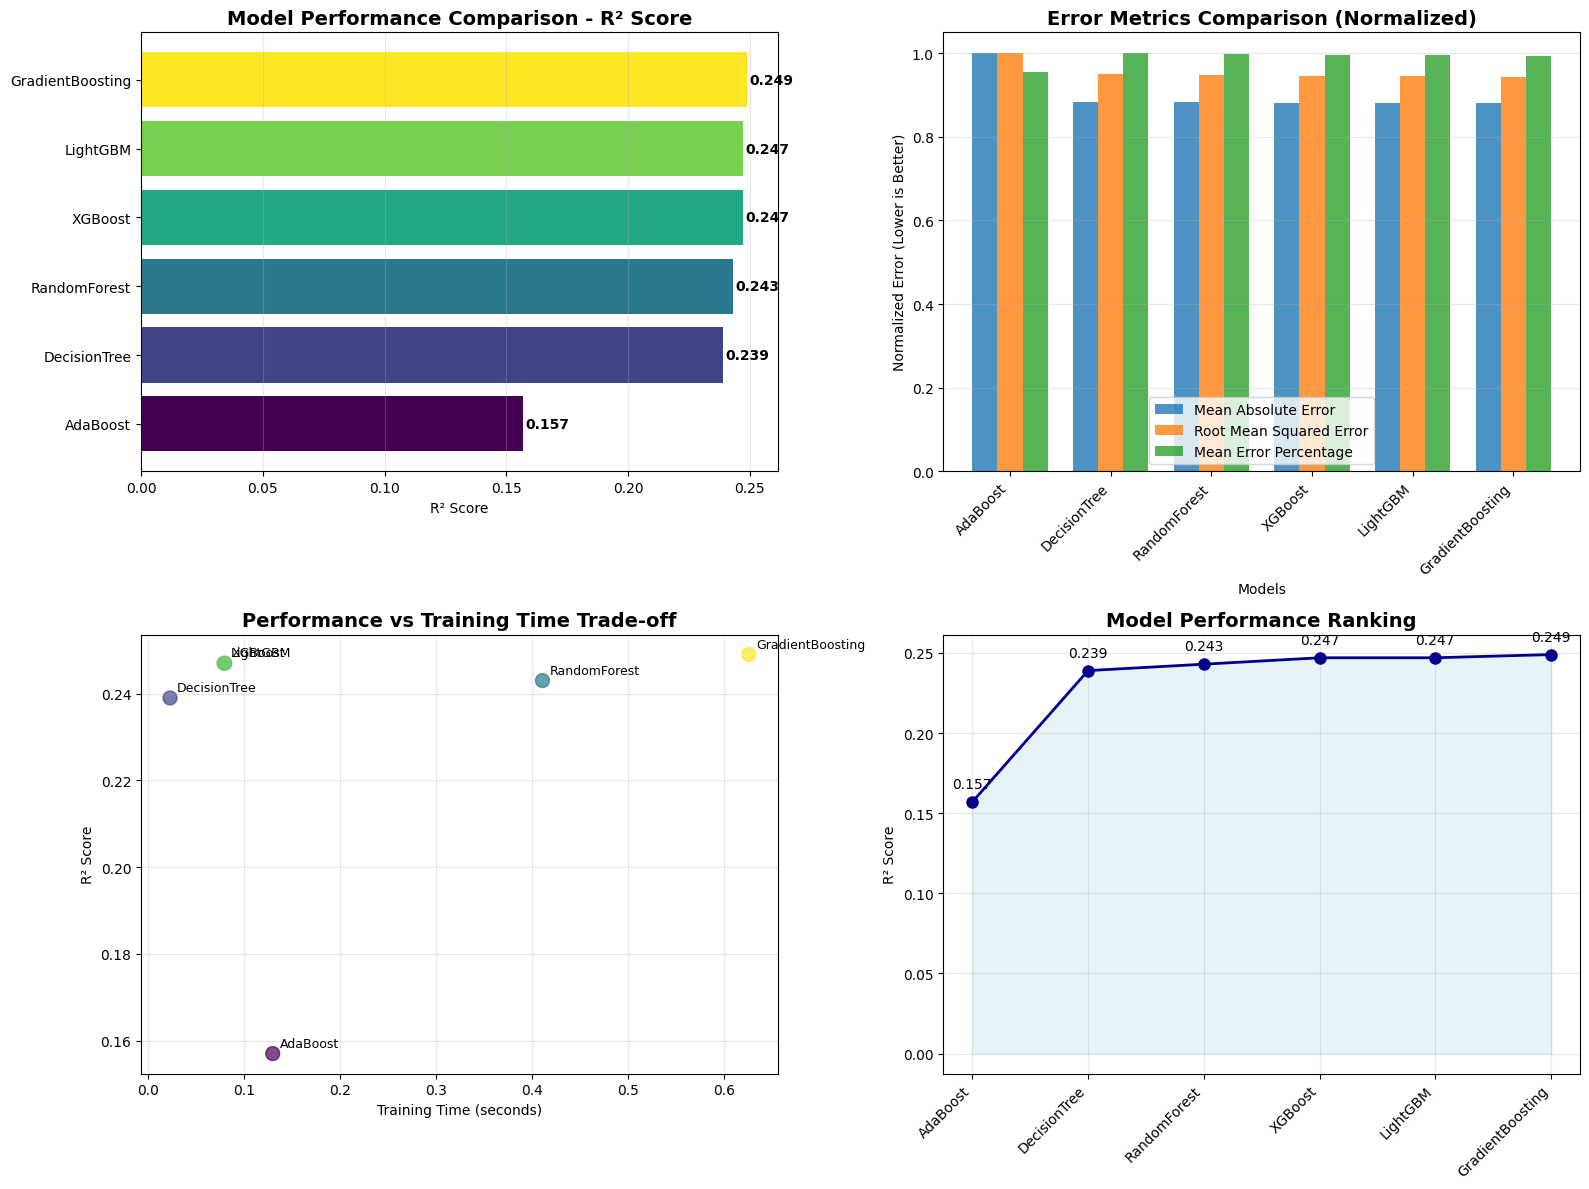


MODEL COMPARISON SUMMARY
🏆 Best Performance: GradientBoosting (R² = 0.2490)
⚡ Fastest Training: DecisionTree (0.023s)
📊 Average R² Score: 0.2303
📈 Performance Range: 0.1570 - 0.2490


In [54]:
# Generate comprehensive model comparison charts
print("Creating Model Comparison Visualizations...")
comparison_results = create_model_comparison_charts()

In [55]:
def detailed_model_metrics_table():
    """
    Create a detailed comparison table of all model metrics.
    """
    results_file = "reg_results.csv"
    
    try:
        results_df = pd.read_csv(results_file)
        
        if results_df.empty:
            print("No results found for detailed comparison.")
            return
        
        # Group by method and show best results
        print("\n" + "="*100)
        print("DETAILED MODEL PERFORMANCE METRICS")
        print("="*100)
        
        # Basic models comparison
        basic_models = results_df[results_df['Method'] == 'Basic'].copy()
        if not basic_models.empty:
            print("\n🔸 BASIC MODELS COMPARISON:")
            print("-" * 60)
            
            # Get best result for each model type
            basic_best = basic_models.groupby('Model Name').apply(
                lambda x: x.loc[x['R Square Score'].idxmax()]
            ).reset_index(drop=True)
            
            display_cols = ['Model Name', 'R Square Score', 'Mean Absolute Error (MAE)', 
                          'Root Mean Squared Error (RMSE)', 'Train Time (s)', 'Feature Columns']
            available_cols = [col for col in display_cols if col in basic_best.columns]
            
            print(basic_best[available_cols].round(4).to_string(index=False))
        
        # Manual tuning comparison
        manual_models = results_df[results_df['Method'] == 'Manual Tuning'].copy()
        if not manual_models.empty:
            print("\n🔸 MANUAL TUNING RESULTS:")
            print("-" * 60)
            
            display_cols = ['Model Name', 'R Square Score', 'Parameters', 'Train Time (s)']
            available_cols = [col for col in display_cols if col in manual_models.columns]
            
            manual_sorted = manual_models.sort_values('R Square Score', ascending=False)
            print(manual_sorted[available_cols].round(4).to_string(index=False))
        
        # GridSearch comparison
        grid_models = results_df[results_df['Method'] == 'GridSearchCV'].copy()
        if not grid_models.empty:
            print("\n🔸 GRIDSEARCHCV RESULTS:")
            print("-" * 60)
            
            display_cols = ['Model Name', 'CV Score (R²)', 'R Square Score', 'Parameters', 'Train Time (s)']
            available_cols = [col for col in display_cols if col in grid_models.columns]
            
            grid_sorted = grid_models.sort_values('R Square Score', ascending=False)
            print(grid_sorted[available_cols].round(4).to_string(index=False))
        
        # Overall best performers
        print("\n🏆 TOP 5 BEST PERFORMING MODELS (ALL METHODS):")
        print("-" * 60)
        
        top_models = results_df.nlargest(5, 'R Square Score')
        display_cols = ['Model Name', 'Method', 'R Square Score', 'Mean Absolute Error (MAE)', 'Train Time (s)']
        available_cols = [col for col in display_cols if col in top_models.columns]
        
        print(top_models[available_cols].round(4).to_string(index=False))
        
        # Statistical summary by method
        print("\n📊 PERFORMANCE STATISTICS BY METHOD:")
        print("-" * 60)
        
        method_stats = results_df.groupby('Method')['R Square Score'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(4)
        method_stats.columns = ['Count', 'Mean R²', 'Std Dev', 'Min R²', 'Max R²']
        print(method_stats.to_string())
        
        return results_df
        
    except FileNotFoundError:
        print(f"Results file '{results_file}' not found.")
        return None
    except Exception as e:
        print(f"Error creating detailed metrics table: {e}")
        return None

In [56]:
# Display detailed model metrics comparison table
detailed_results = detailed_model_metrics_table()


DETAILED MODEL PERFORMANCE METRICS

🔸 BASIC MODELS COMPARISON:
------------------------------------------------------------
      Model Name  R Square Score  Mean Absolute Error (MAE)  Root Mean Squared Error (RMSE)  Train Time (s)                      Feature Columns
        AdaBoost           0.157                     12.790                          17.538           0.130 EDUC, AGE_12, LFSSTAT, GENDER, IMMIG
    DecisionTree           0.239                     11.311                          16.665           0.023 EDUC, AGE_12, LFSSTAT, GENDER, IMMIG
GradientBoosting           0.249                     11.269                          16.561           0.626 EDUC, AGE_12, LFSSTAT, GENDER, IMMIG
        LightGBM           0.247                     11.267                          16.574           0.079 EDUC, AGE_12, LFSSTAT, GENDER, IMMIG
    RandomForest           0.243                     11.290                          16.623           0.411 EDUC, AGE_12, LFSSTAT, GENDER, IMMIG
     

/tmp/ipykernel_1592577/792921124.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  basic_best = basic_models.groupby('Model Name').apply(



FEATURE IMPORTANCE COMPARISON

Training Random Forest for feature importance analysis...


Random Forest R² Score: 0.2386

Training XGBoost for feature importance analysis...
XGBoost R² Score: 0.2447

Training Gradient Boosting for feature importance analysis...
Gradient Boosting R² Score: 0.2485


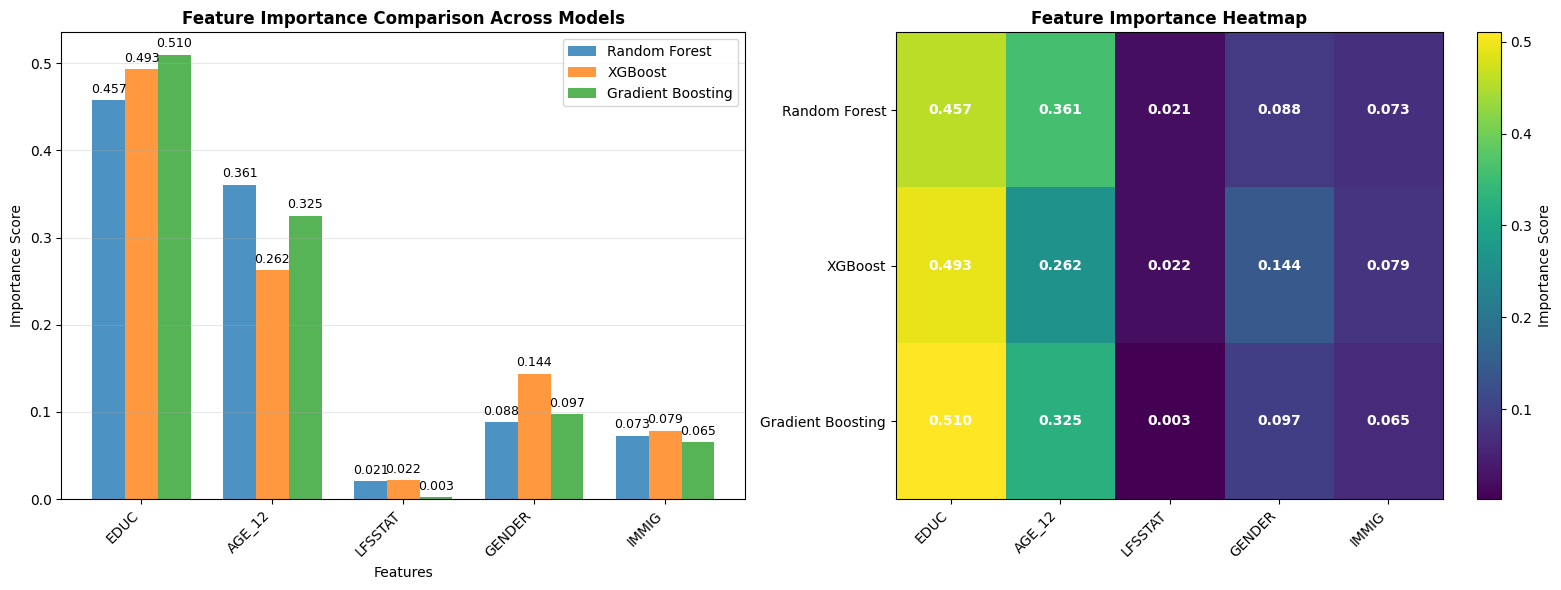


📋 FEATURE RANKING SUMMARY:
--------------------------------------------------

Random Forest:
  1. EDUC: 0.4573
  2. AGE_12: 0.3608
  3. GENDER: 0.0885
  4. IMMIG: 0.0727
  5. LFSSTAT: 0.0208

XGBoost:
  1. EDUC: 0.4934
  2. AGE_12: 0.2624
  3. GENDER: 0.1440
  4. IMMIG: 0.0786
  5. LFSSTAT: 0.0216

Gradient Boosting:
  1. EDUC: 0.5100
  2. AGE_12: 0.3253
  3. GENDER: 0.0971
  4. IMMIG: 0.0651
  5. LFSSTAT: 0.0025


In [57]:
def compare_feature_importance():
    """
    Compare feature importance across different models that support it.
    """
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE COMPARISON")
    print("="*80)
    
    # Define features used in multi-feature models
    features = ['EDUC', 'AGE_12', 'LFSSTAT', 'GENDER', 'IMMIG']
    
    # Train best performing models with feature importance
    models_to_compare = {
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    }
    
    # Prepare data
    df_clean = df.copy()
    df_clean["HRLYEARN"] = df_clean["HRLYEARN"] / 100
    df_clean["AGE_12"] = 10 + df_clean["AGE_12"] * 5
    df_model = df_clean[features + ["HRLYEARN"]].dropna()
    X, y = df_model[features], df_model["HRLYEARN"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train models and collect feature importance
    feature_importance_data = {}
    
    for model_name, model in models_to_compare.items():
        print(f"\nTraining {model_name} for feature importance analysis...")
        model.fit(X_train, y_train)
        
        if hasattr(model, 'feature_importances_'):
            feature_importance_data[model_name] = model.feature_importances_
        
        # Quick performance check
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        print(f"{model_name} R² Score: {r2:.4f}")
    
    # Create feature importance comparison chart
    if feature_importance_data:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Grouped bar chart
        x = np.arange(len(features))
        width = 0.25
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        for i, (model_name, importance) in enumerate(feature_importance_data.items()):
            bars = ax1.bar(x + i*width, importance, width, label=model_name, 
                          color=colors[i], alpha=0.8)
            
            # Add value labels on bars
            for bar, val in zip(bars, importance):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f'{val:.3f}', ha='center', va='bottom', fontsize=9)
        
        ax1.set_xlabel('Features')
        ax1.set_ylabel('Importance Score')
        ax1.set_title('Feature Importance Comparison Across Models', fontweight='bold')
        ax1.set_xticks(x + width)
        ax1.set_xticklabels(features, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        
        # Heatmap style comparison
        importance_df = pd.DataFrame(feature_importance_data, index=features)
        im = ax2.imshow(importance_df.T, cmap='viridis', aspect='auto')
        
        # Add text annotations
        for i in range(len(importance_df.columns)):
            for j in range(len(importance_df.index)):
                text = ax2.text(j, i, f'{importance_df.iloc[j, i]:.3f}',
                               ha="center", va="center", color="white", fontweight='bold')
        
        ax2.set_xticks(range(len(features)))
        ax2.set_xticklabels(features, rotation=45, ha='right')
        ax2.set_yticks(range(len(feature_importance_data)))
        ax2.set_yticklabels(list(feature_importance_data.keys()))
        ax2.set_title('Feature Importance Heatmap', fontweight='bold')
        
        # Add colorbar
        plt.colorbar(im, ax=ax2, label='Importance Score')
        
        plt.tight_layout()
        plt.show()
        
        # Print feature ranking summary
        print(f"\n📋 FEATURE RANKING SUMMARY:")
        print("-" * 50)
        
        for model_name, importance in feature_importance_data.items():
            feature_ranking = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
            print(f"\n{model_name}:")
            for i, (feature, score) in enumerate(feature_ranking, 1):
                print(f"  {i}. {feature}: {score:.4f}")
    
    else:
        print("No models with feature importance found.")

# Execute feature importance comparison
compare_feature_importance()